### Quantify image-based metrics of TB stain with single-cell segmentation geometries

In [82]:
import rasterio as rio
from rasterio.mask import mask
import geopandas as gpd
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import anndata as ad
import cv2
import scipy
import scipy.stats as stats
from scipy.stats import normaltest
from scipy import sparse
from sklearn.preprocessing import StandardScaler
from shapely.geometry import shape, box
from shapely.affinity import translate
from shapely.geometry import Polygon
from tqdm import tqdm
import scanpy as sc
import math
import scipy.io as sio
import gc


After downloading the entire data folder, unzip the .tgz files (unzip any .gz files with the command tar -cvxf filename.tgz). You should end up with a folder containing the following subfolders: 

If you run this code from within its code folder, you should not need to edit anything in order to get it to run. 

## Folder Names
code \
Figures \
Stats \
Annotated_h5ad \
cell_annotations \
postprocessed_counts \
202305231432_TB-CTRL1-MB_VMSC02401 \
202305251147_TB-CTRL2-MB_VMSC02401 \
202305261458_TB-TEST3-MB_VMSC02401 \
202309251210_20230925-RitwicqA-TB_VMSC02401 \
202310091253_AmandaS-TB-02_VMSC02401 \
202310111428_RitwicqA-TB-4b_VMSC02401

In [83]:
dataPath = !pwd
processedDataPath = dataPath+'postprocessed_counts/'

threshold = 300
std_threshold = 150 

layer = 'normalized_to_polyT'
binsize=100
perm_iterations=10000
pval_threshold = 0.001
stat_threshold = 0.15

marker_dict = {'High':['Nos2', 'H2Ab1', 'Irf1','C1qb'], 'Low':['Sparc','Jun','Lyve1'],'Neither':['Irf9','H2K1','Cxcr2']}

In [84]:
def concatenate_h5ad_folder(input_folder,
                            output_folder='None',
                            name = 'concatenated_10x_output',
                            regex = ['donor','tissue','anatomical_position','method','sample','replicate','notes'],
                            regex_sep = '_',
                            counts_threshold=1000,
                            genes_threshold=100,
                            adata_file = 'None',
                            save_frequency = 100):
    
    """
    Take output files from decontx processing and concatenate into anndata object
    """
    
    if output_folder=='None':
        output_folder=input_folder
    
    if not os.path.isdir(input_folder):
        raise SyntaxError('Input folder cannot be found')   
        
    if not os.path.isdir(output_folder):
        raise SyntaxError('output folder cannot be found')   
    
    adata = sc.AnnData()
        
    files = [i for i in os.listdir(input_folder) if i.endswith(('.h5ad','.h5ad.gz'))]
    print("first file: ",files[0])
    count = 0
    for file in tqdm(files):
        
        
        info = file.split(".")[0] #assuming information is present in the filename
        if not file.startswith('2023'):
            continue
        #add something to check whether a given sample is already present in the adata file
        if adata_file!='None':
            if info in list(adata.obs['10X_run']):
                print('The sample ', info,' is already in the object. Skipping.')
                continue
        info_split = info.split(regex_sep)
        if len(info_split)<len(regex):
            print('Warning: the sample ',info,' does not have enough metadata information, ',regex[len(info_split):],' will be excluded')
            regex_fix = regex[:len(info_split)]
        else:
            regex_fix = regex
            
            
        print('reading ',file)
        adata_interim = sc.read_h5ad(os.path.join(input_folder,file))
        
        #add in .obs - this depends on the actual metadata format
        print('adding .obs columns to anndata object')
        
        adata_interim.obs['full_sample'] = info
           
        for n in range(0,len(regex_fix)):
            adata_interim.obs[regex_fix[n]] = info.split(regex_sep)[n]
        
        adata_interim.obs['cell_id'] = adata_interim.obs['full_sample'] + "_" + adata_interim.obs.index.astype('str')
        adata_interim.obs.set_index('cell_id',inplace=True)
        
        try:
            del adata_interim.obsm
        except:
            adata_interim
        
        for obs_column in adata.obs.columns:
            if "." in obs_column:
                adata.obs[obs_column] = adata.obs[obs_column].astype('str')
            
        if adata.shape[0]>1:  
            adata = ad.concat([adata,adata_interim],join='outer',merge='unique')
            print('added to adata')
        else:
            adata = adata_interim.copy()
            print('copying interim')
            
        adata.obs = adata.obs.astype('str')
        count = count+1
        
        if count == save_frequency:
            adata.write_h5ad(os.path.join(output_folder,name+'.h5ad'))
            count=0
        
        gc.collect()
            
    
    adata.write_h5ad(os.path.join(output_folder,name+'.h5ad'))
    
    return adata

In [85]:
# Helper functions
def load_image_roi(file_name, window_coords):
    try:
        with rio.open(file_name) as aws_file:
            roi = aws_file.read(1, window=rio.windows.Window(*window_coords))
    except OSError:
        print(f"File read error on {file_name}")
        roi = np.zeros([window_coords[3],window_coords[2]])
        
    return np.squeeze(roi)

def convert_eight_bit(img):
    # Normalize contrast before reducing bit depth
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    norm_img = clahe.apply(img)    
    bg_subtract = norm_img - norm_img.min()
    
    if bg_subtract.max() == 0:
        return np.zeros(img.shape, dtype=np.uint8)
    else:
        range_norm = bg_subtract / bg_subtract.max()      
        return np.array(range_norm * 255, dtype=np.uint8)

In [86]:
def load_tb_image_information(dataPath, experimentName, region):
    
    #initialize a dataframe
    df = pd.DataFrame()

    #iterate through the z planes - in this case there are 7
    for z in range(0,7):
        z_level = str(z)
        print('z_level: ', z_level)
    
        # Segmentation boundaries
        geometries = gpd.read_parquet(
            os.path.join(dataPath, experimentName, 'region_' + region, 'cell_boundaries.parquet')).set_index('EntityID')
    #print('Segmentation geometries loaded.')

    # TB stain channel image, AKA cellbound3
        TBmosaicPath = os.path.join(
            dataPath, experimentName, 'region_' + region, 'images', 'mosaic_Cellbound3_z' + z_level + '.tif')

    # DAPI stain channel image
        DAPImosaicPath = os.path.join(
            dataPath, experimentName, 'region_' + region, 'images', 'mosaic_DAPI_z' + z_level + '.tif')
    
    # Cellbound2 stain channel image
        Cellbound2mosaicPath = os.path.join(
            dataPath, experimentName, 'region_' + region, 'images', 'mosaic_Cellbound2_z' + z_level + '.tif')

    #print('Mosaic filepaths loaded.')

    # Micron to mosaic pixel transform
        transformationMatrix = np.loadtxt(
            os.path.join(dataPath, experimentName, 'region_' + region, 'images', 'micron_to_mosaic_pixel_transform.csv'))
    
    # Convert transformation matrix to correct affine transformation format for Geopandas
        t = transformationMatrix
        affine_matrix = [t[0,0], t[0,1], t[1,0], t[1,1], t[0,2], t[1,2]]

    #print('Micron to mosaic pixel transform loaded.')

    # Create new geodataframe column with mosaic pixel units
        geometries_mosaic = geometries.copy()
        geometries_mosaic['Geometry'] = geometries['Geometry'].affine_transform(affine_matrix)

    #print('Mosaic geometries calculated.')

    # Check that we have the right coordinates by overlaying with DAPI channel
    # What are the dimensions of the overall experiment?
        s = rio.open(DAPImosaicPath)
        print('Dimensions of experiment are ' + str(s.width) + ' x ' + str(s.height) + ' in pixels.')

        gdf = geometries_mosaic.copy()
        gdf = gdf[gdf['ZIndex'] == int(z_level)]

        shapes = list(gdf['Geometry'])
        masks = []

        with rio.open(TBmosaicPath) as src:
            for shape in tqdm(shapes):
                out_image, _ = mask(src, shape.geoms, crop=True)
                masks.append(out_image)
        
    # Save array of pixel intensities for each cell
        gdf['TB_intensities'] = pd.Series(dtype='object')
    #for i in tqdm(range(len(gdf))):
        #gdf.loc[:,'TB_intensities'].loc[gdf.index[i]] = masks[i][np.nonzero(masks[i])]
    
    
    #all nonzero TB intensities for each cell
        gdf['TB_intensities'] = [masks[i][np.nonzero(masks[i])] for i in range(len(gdf))] 
    
    #all TB intensities for each cell, including zeros
        gdf['TB_spatial'] = [masks[i].squeeze() for i in range(len(gdf))] 

    # Calculate some metrics

    # Sum signal
        gdf['sum_signal'] = [gdf.iloc[i]['TB_intensities'].sum() for i in range(len(gdf))]

    # Mean (excluding zeros)
        gdf['mean_signal'] = [gdf.iloc[i]['TB_intensities'].mean() for i in range(len(gdf))]
    
    # Median (excluding zeros)
        gdf['median_signal'] = [np.median(gdf.iloc[i]['TB_intensities']) for i in range(len(gdf))]
    
    # Standard deviation (excluding zeros)
        gdf['std_signal'] = [gdf.iloc[i]['TB_intensities'].std() for i in range(len(gdf))]

    # Average of top 100 values
        gdf['top_avg_signal'] = [np.sort(gdf.iloc[i]['TB_spatial'])[::-1][:100].mean() for i in range(len(gdf))]

    #create a data frame we can add to for each z plane:
        add = gdf[['ZIndex','sum_signal','mean_signal','median_signal','std_signal','top_avg_signal']]
        df = pd.concat([df,add])
    return df
    
def make_average_gdf(df,adata):

#find the mean values for each entity across z positions
#add a binary classifier to adata
    avg_signal_df = pd.DataFrame(columns=df.columns)
    for ind in tqdm(list(set(df.index))):
        sub = df.loc[ind]
        avg = sub.mean(axis=0)
        avg_signal_df.loc[ind] = avg

    avg_signal_df.index = [str(i) for i in avg_signal_df.index]

    #subset to only cells that are included in the final object
    avg_signal_df['Entity_ID'] = avg_signal_df.index.astype('str').copy()
    avg_signal_df = avg_signal_df[avg_signal_df.Entity_ID.isin(list(adata.obs.index))].copy()
    avg_signal_df.set_index('Entity_ID',inplace=True)
    print(avg_signal_df.shape)

    return avg_signal_df


In [87]:
def load_vizgen_h5ad(processedDataPath,experimentName, filename, region,
                    min_volume=200, max_volume=5000, min_counts=20, min_dapi = 2000000, TB_threshold = 700000):
    
    #read in the h5ad file
    adata = sc.read_h5ad(processedDataPath+experimentName+'/'+filename)

    #print the number of cells, cells per region, and show the object
    print('number of cells in unfiltered dataset: ',adata.shape[0])
    print('cells per region: ', adata.obs.region.value_counts())

    #filter to one region at a time
    adata = adata[adata.obs.region==region].copy()
    adata

    # Calculate total counts
    adata.obs['total_counts'] = adata.X.toarray().sum(axis=1)
    adata.obs['log_total_counts'] = np.log(adata.obs['total_counts'] + 1)
    
    #print graphs
    #Create thresholds based on the plots above, and plot those lines onto the data. 
    fig, axes = plt.subplots(1,4, figsize=(12,4))

    # Cell volume
    bins = np.logspace(0,4,20)
    ax = axes[0]
    ax.hist(adata.obs['volume'], bins=bins,cumulative=True,density=True)
    ax.set_xlabel('cell volume (um^3)')
    ax.set_ylabel('count')
    ax.set_xscale('log')
    ax.axvline(min_volume,color='red')
    ax.axvline(max_volume,color='black')
    ax.axhline(0.05,color='red')

    # Total transcripts per cell
    bins = np.logspace(0,3.5,20)
    ax = axes[1]
    ax.hist(adata.obs['total_counts'], bins=bins,cumulative=True,density=True)
    ax.set_xlabel('total transcripts')
    ax.set_ylabel('count')
    ax.set_xscale('log')
    ax.axvline(min_counts,color='red')
    ax.axhline(0.20,color='red')


    # DAPI signal per cell
    bins = np.logspace(2,8,20)
    ax = axes[2]
    ax.hist(adata.obs['DAPI_high_pass'], bins=bins,cumulative=True,density=True)
    ax.set_xlabel('DAPI')
    ax.set_ylabel('fraction of cells')
    ax.set_xscale('log')
    #ax.set_yscale('log')
    ax.axvline(min_dapi,color='red')
    ax.axhline(0.1,color='red')

    # TB signal per cell
    bins = np.logspace(2,6,20)
    ax = axes[3]
    ax.hist(adata.obs['Cellbound3_high_pass'], bins=bins,cumulative=True,density=True)
    ax.set_xlabel('TB stain')
    ax.set_ylabel('count')
    ax.set_xscale('log')
    ax.axhline(0.95,color='black')
    ax.axvline(TB_threshold,color='black')

    print('saving figure')
    fig.savefig(dataPath+'Figures/'+experimentName+'region'+str(region)+'_basicQC.pdf')
    print("size of adata object: ", adata.shape)
    return adata

def filter_h5ad(adata,min_volume=200, max_volume=5000, min_counts=20, min_dapi = 2000000):
    #filter the object based on the thresholds above
    cells = adata.shape[0]
    adata = adata[(adata.obs['volume'] > min_volume) &
         (adata.obs['volume'] < max_volume) &
         (adata.obs['total_counts'] > min_counts) &
         (adata.obs['DAPI_high_pass'] > min_dapi)].copy()
    print('Filtering complete: ' + str(len(adata)) + ' cells remaining out of ' + str(cells) + ' original cells.')
    return adata

def show_spatial_plots(adata, clipx, experimentName, region,figsize = (10,10)):
    #Show the section and add lines for any removal of damage
    fig, ax = plt.subplots(figsize=figsize)
    sc.pl.spatial(adata, color='Cellbound3_high_pass', spot_size=50, ax=ax,color_map='OrRd',vmax=5000000)

    fig, ax = plt.subplots(figsize=figsize)
    ax.axvline(clipx,color='red')
    ax.axvline(clipx+1000,color='blue')

    if experimentName == '202309251210_20230925-RitwicqA-TB_VMSC02401' and region=='1':
        ax.axhline(6500,color='red')
        ax.axhline(7500,color='blue')
    sc.pl.spatial(adata, color='log_total_counts', spot_size=30, ax=ax)
    
def sc_preprocess(adata):
    # Basic scanpy preprocessing
    adata.X = adata.layers['counts'].copy()
    sc.pp.normalize_total(adata,target_sum=100)
    sc.pp.log1p(adata)

    #save normalized data
    adata.layers['log_normalized'] = adata.X.copy()
    print('log normalized')

    #scale data
    sc.pp.scale(adata)
    adata.layers['scale_data'] = adata.X.copy()
    print('scaled')

    #run dimensional reduction
    print('calculating pcs')
    sc.pp.pca(adata)

    print('calculating umap')
    sc.pp.neighbors(adata)
    sc.tl.umap(adata)
    sc.tl.leiden(adata, resolution=0.5)

    print('Scanpy processing complete.')
    #check that counts remain
    print(adata.layers['counts'][:1,:5])
    return adata

def tbcells_only_calculate_distance_to_tb(adata):
    adata.obs['distance_to_tb'] = -100
    #calculate euclidean distance from each of these cells to every other cell, find the minimum
    tb_cells = adata.obs.index[adata.obs.TB_class_from_images=='High']
    
    #iterate over all tb cells
    #find the location of the cell in space
    #X_spatial is not an x-coordinate, it's a point
    
    for cell in tqdm(list(tb_cells)):
        dist = []
        cell_loc = np.round(list([adata.obs.center_x[cell],adata.obs.center_y[cell]]),decimals=2)
    
        #iterate over all TB+ cells and find the distance from each one to the cell in question
        for tb_cell in tb_cells:
            tb_cell_loc = np.round(list([adata.obs.center_x[tb_cell],adata.obs.center_y[tb_cell]]),decimals=2)
            new_dist = np.round(math.dist(cell_loc,tb_cell_loc),decimals=2)
            dist.append(new_dist)

        #find the minimum distance to the 2nd tb+ cell
        try:
            min_dist = sorted(dist,reverse=False)[2]
        except:
            min_dist = 401
            print('not enough cells to calculate min distance')
        
        #add this to the object
        adata.obs.loc[cell,'distance_to_tb'] = min_dist
        
    #show any outliers in terms of cellbound 3 (tb) or distance to tb, print a graph
    print("cells with TB signal above 5 million:", adata[adata.obs.Cellbound3_high_pass>5e6].shape)
    sc.pl.scatter(adata[adata.obs.TB_class_from_images=='High'],x='center_x',y='distance_to_tb',color='Cellbound3_high_pass')
    
    return adata

#calculate euclidean distance from each of the tb+ cells to every other cell, find the minimum
def calculate_distance_to_tb(adata):
    if 'High' in set(adata.obs.TB_class_from_images):

        adata.obs['distance_to_tb'] = -100


        tb_cells = adata.obs.index[adata.obs.TB_class_from_images=='High']
        count=1
    #iterate over all cells
        for cell in tqdm(list(adata.obs.index)):
            dist = []
    
        #if the cell is TB+, distance = 0
            if adata.obs.loc[cell,'TB_class_from_images']=='High':
                adata.obs.loc[cell,'distance_to_tb'] = 0
                continue
        
            cell_loc = np.round(list([adata.obs.center_x[cell],adata.obs.center_y[cell]]),decimals=2)
    #if the cell is not TB+, calculate its distance from each TB+ cell
    #iterate over all TB+ cells and find the distance from each one to the cell in question
            for tb_cell in tb_cells:
                tb_cell_loc = np.round(list([adata.obs.center_x[tb_cell],adata.obs.center_y[tb_cell]]),decimals=2)
                new_dist = np.round(math.dist(cell_loc,tb_cell_loc),decimals=2)
                dist.append(new_dist)

    #find the minimum distance
            min_dist = min(dist)
    
    #add this to the object
            adata.obs.loc[cell,'distance_to_tb'] = min_dist
    else:
        adata.obs['distance_to_tb'] = 5000
    return adata

#run a permutation test comparing each transcript from within the binsize relative to a tb+ cell against all cells
def permutation_test_for_tb_loc(adata,layer='log_normalized',binsize=100,perm_iterations=1000):

    if isinstance(adata.layers[layer], scipy.sparse._csr.csr_matrix):
        adata_df = pd.DataFrame.sparse.from_spmatrix(adata.layers[layer])
        adata_df = adata_df.sparse.to_dense()
    else:
        adata_df = pd.DataFrame(adata.layers[layer])
    adata_df.columns = adata.var.index
    adata_df.index = adata.obs.index
    adata_df['distance_real'] = adata.obs['distance_to_tb'].copy()
    adata_df.columns = [i.replace('-','') for i in adata_df.columns]

    adata_df['Bin'] = 'Null'

    #for the first 4 bins, plot the distribution on top of this one in a different color
    adata_df.loc[(adata_df.distance_real>=6*binsize) & (adata_df.distance_real<7*binsize),'Bin'] = 'Bin7'
    adata_df.loc[(adata_df.distance_real>=3*binsize) & (adata_df.distance_real<4*binsize),'Bin'] = 'Bin4'
    adata_df.loc[(adata_df.distance_real>=2*binsize) & (adata_df.distance_real<3*binsize),'Bin'] = 'Bin3'
    adata_df.loc[(adata_df.distance_real>=binsize) & (adata_df.distance_real<2*binsize),'Bin'] = 'Bin2'
    adata_df.loc[adata_df.distance_real<binsize,'Bin'] = 'Bin1'
    adata_df.loc[adata_df.distance_real==0,'Bin'] = 'Bin0'
    print("number of cells per bin: ",adata_df.Bin.value_counts())
    adata_df = adata_df.sort_values('Bin',ascending=True)

    #permutation test ~43 iterations/second
    df_results = pd.DataFrame(columns=['sample_stat','average_stat','p_value'])
    for transcript in tqdm(adata_df.columns[:140]):
        #calculate a "null distribution" excluding TB+ and nearby cells
        ref_average = np.mean(adata_df.loc[~adata_df['Bin'].isin(['Bin1','Bin0']),transcript])
        #print(ref_average)
                              
        sample_stat = np.mean(adata_df.loc[adata_df['Bin']=='Bin1',transcript]) - ref_average #calculate the difference in means between your bin1 distribution and the null distribution
        stats = np.zeros(perm_iterations)
        for k in range(perm_iterations):
            labels = np.random.permutation((adata_df['Bin'] == 'Bin1').values) #randomly rearrange the bin labels so you get another sample in 'Bin1'
            stats[k] = np.mean(adata_df[transcript][labels]) - ref_average #for each of 1000 iterations, calculate the difference between the random Bin1 Nos2 values and the null distribution
    
        if sample_stat>=0:
            p_value = np.mean(stats > sample_stat)
        if sample_stat<0:
            p_value = np.mean(stats < sample_stat)
    #save the stat and p-value per transcript
        df_results.loc[transcript] = [sample_stat,np.mean(stats),p_value] 

    df_results = df_results.sort_values('p_value',ascending=True)
    return adata_df, df_results

In [88]:
def plot_tb_altered_transcripts(sc_data,pval_threshold, stat_threshold, df_results,experimentName, region,perm_iterations):
    top_hits = df_results[(df_results.p_value<pval_threshold)].sort_values('sample_stat',ascending=False)
    top_hits = list(top_hits[top_hits.sample_stat>stat_threshold].index)
    top_hits = [i for i in top_hits if not i.startswith('Blank')]

    bottom_hits =df_results[(df_results.p_value<pval_threshold) & (df_results.sample_stat< -stat_threshold)].index
    bottom_hits = [i for i in bottom_hits if not i.startswith('Blank')]

    #show violin or feature plots of these genes in the smartseq data
   
    if len(top_hits)>2:
        sc.pl.heatmap(sc_data,top_hits,groupby='leiden',show_gene_labels=True)
        #sc.pl.stacked_violin(sc_data,top_hits,groupby='leiden',rotation=90,title = 'Upregulated near TB')
    if len(bottom_hits)>2:
        sc.pl.heatmap(sc_data,bottom_hits,groupby='leiden',show_gene_labels=True)
        #sc.pl.stacked_violin(sc_data,bottom_hits,groupby='leiden',rotation=90,title='Downregulated near TB')
    
    allprobes = [i for i in list(df_results.index) if not i.startswith('Blank')]

    sc_data.var['UpNearTB'] = False
    sc_data.var.loc[sc_data.var.index.isin(top_hits),'UpNearTB'] = True

    sc_data.var['DownNearTB'] = False
    sc_data.var.loc[sc_data.var.index.isin(bottom_hits),'DownNearTB'] = True

    sc_data.var['UnchangedNearTB'] = False
    sc_data.var.loc[sc_data.var.index.isin(allprobes),'UnchangedNearTB'] = True
    sc_data.var.loc[sc_data.var['UpNearTB']==True,'UnchangedNearTB'] = False
    sc_data.var.loc[sc_data.var['DownNearTB']==True,'UnchangedNearTB'] = False

    print("up near TB: ", len(top_hits), "\ndown near TB:", len(bottom_hits))

    sc.pp.calculate_qc_metrics(sc_data,qc_vars=['UpNearTB','DownNearTB','UnchangedNearTB'],inplace=True)

    fig,ax = plt.subplots(figsize=(5,3))
    ax.set_ylim(0,7)
    #sc.pl.violin(sc_data,['total_counts_UpNearTB','pct_counts_UpNearTB','total_counts_DownNearTB','pct_counts_DownNearTB'],groupby='leiden',rotation=90)
    sc.pl.violin(sc_data,['pct_counts_UpNearTB'],groupby='leiden',rotation=90,inner='quartile',save = experimentName+'region'+str(region)+'ViolinPlot_UP_TB.pdf',ax=ax)
    fig,ax = plt.subplots(figsize=(5,3))
    ax.set_ylim(0,7)
    sc.pl.violin(sc_data,['pct_counts_DownNearTB'],groupby='leiden',rotation=90,inner='quartile',save = experimentName+'region'+str(region)+experimentName+'region'+str(region)+'ViolinPlot_Down_TB.pdf',ax=ax)

    fig,ax = plt.subplots(figsize=(5,3))
    ax.set_ylim(0,7)
    sc.pl.violin(sc_data,['pct_counts_UnchangedNearTB'],groupby='leiden',rotation=90,inner='quartile',save = experimentName+'region'+str(region)+'ViolinPlot_NOCHANGE_TB.pdf',ax=ax)

    print(df_results.p_value[df_results.p_value>0].min())
    df_results.loc[df_results.p_value==0,'p_value'] = 0.9/perm_iterations
    df_results.to_csv(dataPath+'Stats/stats'+experimentName+'_region'+str(region)+'.csv')

    plt.figure(figsize=(20,10))
    plt.scatter(x = df_results.sample_stat, y=-np.log10(df_results.p_value))
    plt.xlabel('difference in means, Bin1 - Null')
    plt.ylabel('-log p value')

    for i in range(df_results.shape[0]):
        plt.text(x=df_results.sample_stat[i],y=-np.log10(df_results.p_value[i]),s=df_results.index[i], 
              fontdict=dict(color='black',size=10))
    
    plt.savefig(dataPath+'Figures/volcano'+experimentName+'_region'+str(region)+'.pdf')
    return sc_data

def plot_cumulative_dist(marker_dict,adata_df,experimentName,region,ymax = 0):
#run for each set of marker genes
    for celltype in list(marker_dict.keys()):
   
        for transcript in marker_dict[celltype]:
            if ymax==0:
                ymax_new = max(adata_df[transcript])
            else:
                ymax_new=ymax
    #if transcript not in ['Nos2','C1qa','C1qb','C1qc','Fcgr4','Lyve1']:
        #continue
  
            fig,ax = plt.subplots(figsize=(5,3))
            sns.histplot(data = adata_df,
                 x=transcript, 
                 bins=10000, 
                 binrange=(0,ymax_new),
                 stat="density",
                 element="step", 
                 fill=False, 
                 cumulative=True,
                color='Grey',
                alpha=0.5)
        
    
            sns.histplot(data = adata_df[adata_df.Bin!='Null'],
                 x=transcript, 
                 hue='Bin', 
                 bins=10000, 
                 binrange=(0,ymax_new),
                 stat="density",
                 element="step", 
                 fill=False, 
                 cumulative=True, 
                 common_norm=False,
                 palette = ['Black','Red','Orange','Green','Teal','Blue'])
            ax.set_xlabel(celltype)
            ax.set_ylabel('Cumulative Distribution')
            ax.set_title(transcript)
            ax.set_ylim(0,1)
            fig.savefig(dataPath+'Figures/'+experimentName+'_region'+str(region)+'_'+transcript+'_histogram.pdf') 

In [89]:
def assign_tb_pos_cells(adata,avg_signal_df, threshold, std_threshold,experimentName, region):
    #add metrics to adata object
    adata.obs.loc[avg_signal_df.index,'TB_std'] = avg_signal_df.std_signal
    adata.obs.loc[avg_signal_df.index,'TB_mean'] = avg_signal_df.mean_signal
    adata.obs.loc[avg_signal_df.index,'TB_topaverage'] = avg_signal_df.top_avg_signal

    if experimentName=='202309251210_20230925-RitwicqA-TB_VMSC02401' and region=='2':
        threshold = 250
    
    adata.obs['TB_class_from_images'] = 'High'
    adata.obs.loc[adata.obs.TB_topaverage<=threshold,'TB_class_from_images'] = 'Low'
    print('initial thresholding',adata.obs.TB_class_from_images.value_counts(sort=False))
    adata.obs.loc[(adata.obs.TB_std<=std_threshold)&(adata.obs.TB_topaverage>threshold),'TB_class_from_images'] = 'Removed'
    print('with sd cutoff',adata.obs.TB_class_from_images.value_counts(sort=False))

    #run distance calculation
    adata = tbcells_only_calculate_distance_to_tb(adata)

    #print out initial counts, remove cells with high TB values and lone cells
    adata.obs.loc[adata.obs.Cellbound3_high_pass>5e6,'TB_class_from_images']='Removed'
    print('removed super high fluorescent cells', adata.obs.TB_class_from_images.value_counts(sort=False))
    adata.obs.loc[adata.obs.distance_to_tb>400,'TB_class_from_images']='Removed' 
    print("removed lone cells", adata.obs.TB_class_from_images.value_counts(sort=False))

    if experimentName=='202305261458_TB-TEST3-MB_VMSC02401':
        adata.obs.loc[adata.obs.center_x>4000,'TB_class_from_images'] = 'Removed'
        print(adata.obs.TB_class_from_images.value_counts())
    
    adata.obs.TB_class_from_images.to_csv(dataPath+'cell_annotations/'+experimentName+'region'+str(region)+'TB_binary.csv')
    adata.obs.TB_class_from_images.value_counts()   
    
    fig, ax = plt.subplots(figsize=(20,10))
    sc.pl.spatial(adata,color='TB_class_from_images',spot_size=30,palette=['red','lightgrey','grey'],ax=ax)

    sc.pl.violin(adata,['center_x','center_y'],groupby='TB_class_from_images')
    sc.pl.violin(adata,['TB_std','TB_mean'],groupby='TB_class_from_images')
    sc.pl.violin(adata,['TB_topaverage','Cellbound3_high_pass'],groupby='TB_class_from_images')
    sc.pl.scatter(adata,x='TB_topaverage',y='TB_std',color='TB_class_from_images',size=30)

    fig,ax = plt.subplots(figsize=(10,10))
    ax.axvline(8000,color='black')
    ax.axvline(9000,color='black') #1 mm
    sc.pl.spatial(adata,spot_size=20,color = 'TB_class_from_images',palette=['red','lightgrey','grey'],ax=ax)
    fig.savefig(dataPath+'Figures/'+experimentName+'region'+str(region)+'1mmscale_TBclass.pdf')       
    return adata

****1. Load in Shoshana's final smartseq object, remove neutrophils, and edit gene names:****

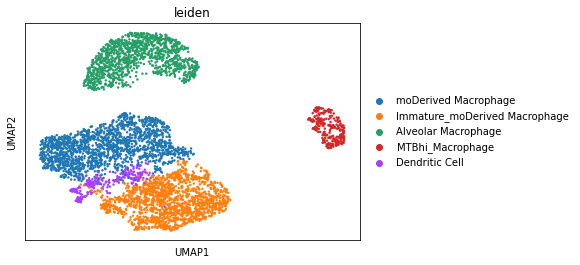

In [90]:
sc_data = sc.read_h5ad(dataPath+'Annotated_h5ad/scRNAseq_MNP_SS2only.h5ad')
sc_data = sc_data[sc_data.obs.leiden!='Neutrophil'].copy()
sc.pl.umap(sc_data,color = 'leiden')
sc_data.var_names = [i.replace('-','') for i in sc_data.var_names]

****2. Filter and QC the Vizgen h5ad file****

In [91]:
#make a table
experiment_df = pd.DataFrame(columns = ['experimentName','region','clipx'])
experiment_df.loc[0] = ['202305231432_TB-CTRL1-MB_VMSC02401','0',0]
experiment_df.loc[1] = ['202305231432_TB-CTRL1-MB_VMSC02401','1',0]
experiment_df.loc[2] = ['202305231432_TB-CTRL1-MB_VMSC02401','2',0]
experiment_df.loc[3] = ['202305251147_TB-CTRL2-MB_VMSC02401','0',0]
experiment_df.loc[4] = ['202305251147_TB-CTRL2-MB_VMSC02401','1',0]
experiment_df.loc[5] = ['202305261458_TB-TEST3-MB_VMSC02401','1',2000]
experiment_df.loc[7] = ['202309251210_20230925-RitwicqA-TB_VMSC02401','1',7500]
experiment_df.loc[8] = ['202309251210_20230925-RitwicqA-TB_VMSC02401','2',2500]
experiment_df.loc[9] = ['202310091253_AmandaS-TB-02_VMSC02401','0',0]
experiment_df.loc[10] = ['202310091253_AmandaS-TB-02_VMSC02401','1',0]
experiment_df.loc[11] = ['202310091253_AmandaS-TB-02_VMSC02401','2',0]
experiment_df.loc[12] = ['202310111428_RitwicqA-TB-4b_VMSC02401','1',0]
experiment_df.loc[13] = ['202310111428_RitwicqA-TB-4b_VMSC02401','2',0]
experiment_df

experimentName region  clipx
0            202305231432_TB-CTRL1-MB_VMSC02401      0      0
1            202305231432_TB-CTRL1-MB_VMSC02401      1      0
2            202305231432_TB-CTRL1-MB_VMSC02401      2      0
3            202305251147_TB-CTRL2-MB_VMSC02401      0      0
4            202305251147_TB-CTRL2-MB_VMSC02401      1      0
5            202305261458_TB-TEST3-MB_VMSC02401      1   2000
7   202309251210_20230925-RitwicqA-TB_VMSC02401      1   7500
8   202309251210_20230925-RitwicqA-TB_VMSC02401      2   2500
9          202310091253_AmandaS-TB-02_VMSC02401      0      0
10         202310091253_AmandaS-TB-02_VMSC02401      1      0
11         202310091253_AmandaS-TB-02_VMSC02401      2      0
12        202310111428_RitwicqA-TB-4b_VMSC02401      1      0
13        202310111428_RitwicqA-TB-4b_VMSC02401      2      0

Set all variables

## Run all the code on each section

202305231432_TB-CTRL1-MB_VMSC02401 0 0
number of cells in unfiltered dataset:  64788
cells per region:  2    50074
1    12312
0     2402
Name: region, dtype: int64
saving figure
size of adata object:  (2402, 140)
Filtering complete: 1198 cells remaining out of 2402 original cells.


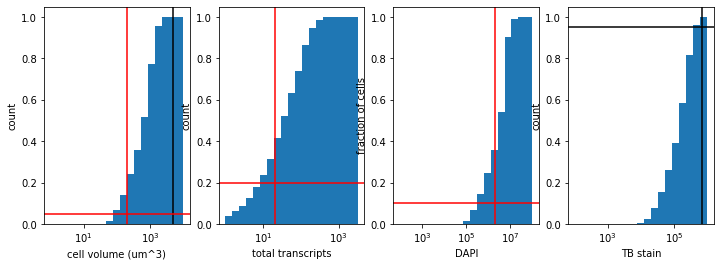

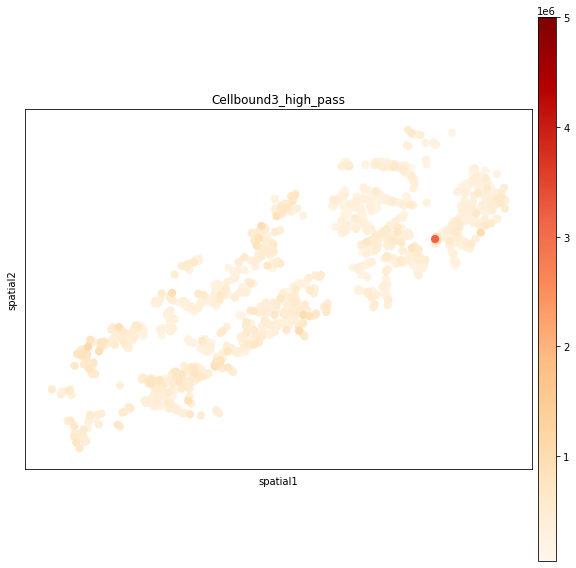

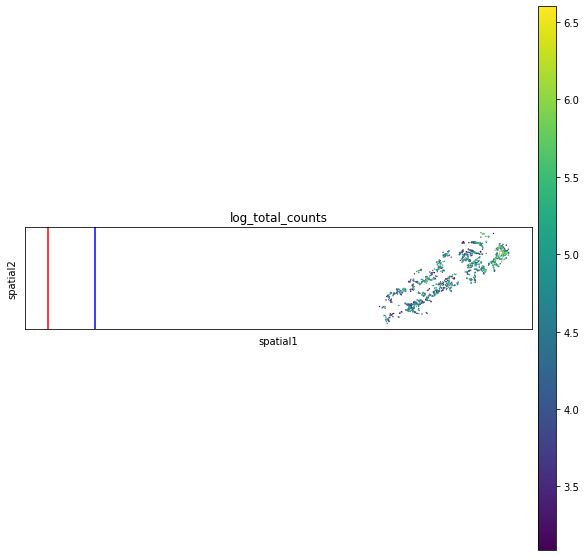

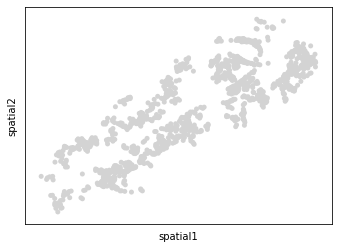

log normalized
scaled
calculating pcs
calculating umap
Scanpy processing complete.
  (0, 0)	1.0
  (0, 1)	2.0
z_level:  0
Dimensions of experiment are 26295 x 18621 in pixels.


100%|██████████| 2402/2402 [00:03<00:00, 765.59it/s] 


z_level:  1
Dimensions of experiment are 26295 x 18621 in pixels.


100%|██████████| 2402/2402 [00:03<00:00, 795.41it/s] 


z_level:  2
Dimensions of experiment are 26295 x 18621 in pixels.


100%|██████████| 2402/2402 [00:03<00:00, 745.80it/s] 


z_level:  3
Dimensions of experiment are 26295 x 18621 in pixels.


100%|██████████| 2402/2402 [00:03<00:00, 748.62it/s] 


z_level:  4
Dimensions of experiment are 26295 x 18621 in pixels.


100%|██████████| 2402/2402 [00:02<00:00, 824.55it/s] 


z_level:  5
Dimensions of experiment are 26295 x 18621 in pixels.


100%|██████████| 2402/2402 [00:03<00:00, 792.26it/s] 


z_level:  6
Dimensions of experiment are 26295 x 18621 in pixels.


100%|██████████| 2402/2402 [00:02<00:00, 982.56it/s]


(1198, 6)
(1198, 6) (1198, 140)
initial thresholding Low     1196
High       2
Name: TB_class_from_images, dtype: int64
with sd cutoff Low     1196
High       2
Name: TB_class_from_images, dtype: int64


100%|██████████| 2/2 [00:00<00:00, 3489.44it/s]


not enough cells to calculate min distance
not enough cells to calculate min distance
cells with TB signal above 5 million: (0, 140)


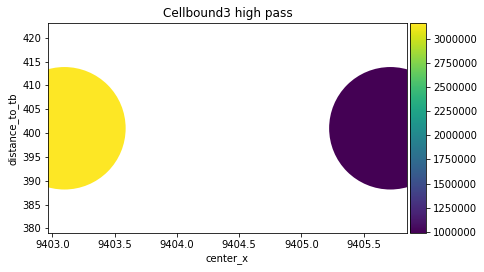

removed super high fluorescent cells Low     1196
High       2
Name: TB_class_from_images, dtype: int64
removed lone cells Low        1196
Removed       2
Name: TB_class_from_images, dtype: int64


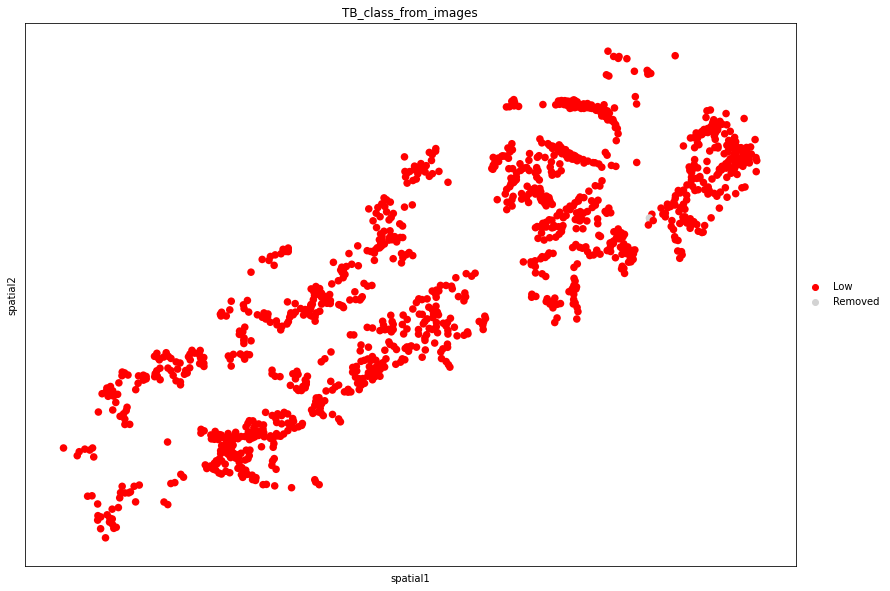

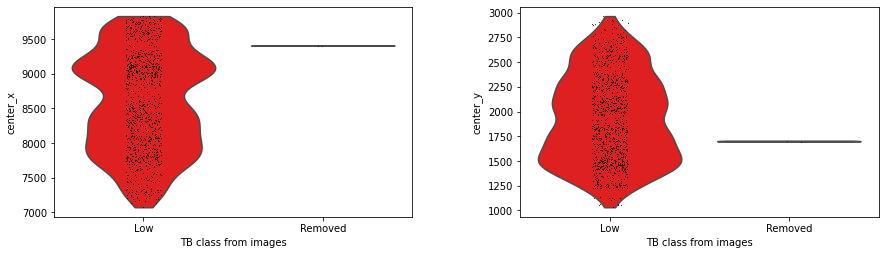

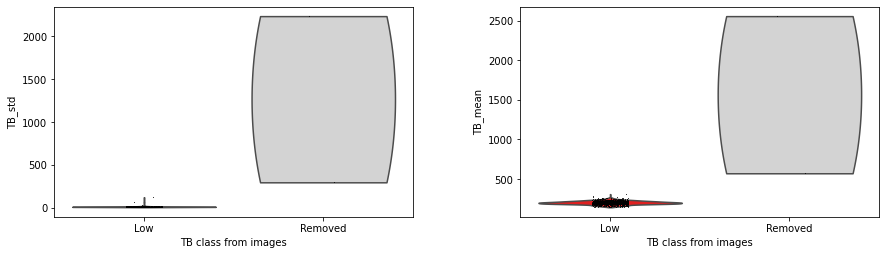

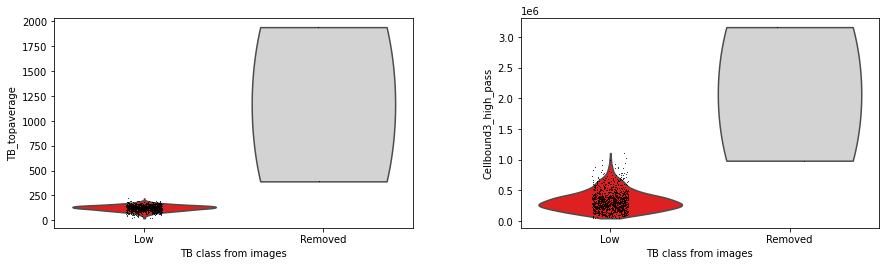

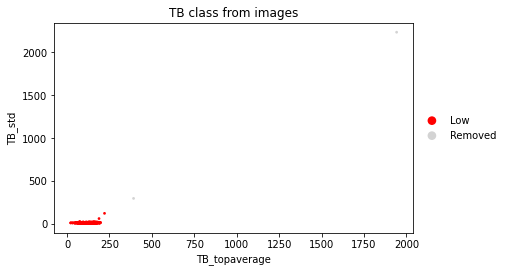

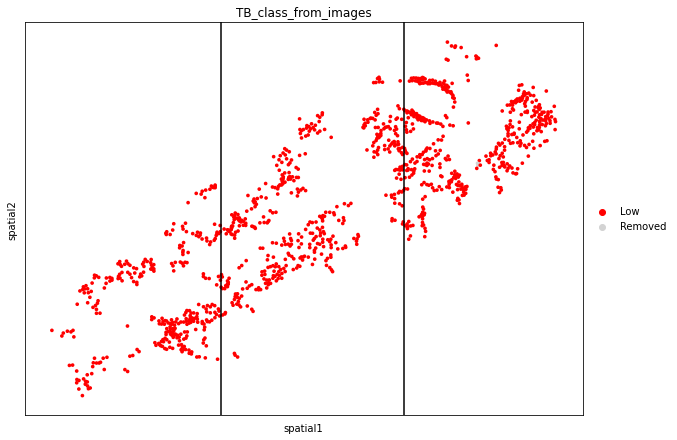

202305231432_TB-CTRL1-MB_VMSC02401 1 0
number of cells in unfiltered dataset:  64788
cells per region:  2    50074
1    12312
0     2402
Name: region, dtype: int64
saving figure
size of adata object:  (12312, 140)
Filtering complete: 8123 cells remaining out of 12312 original cells.


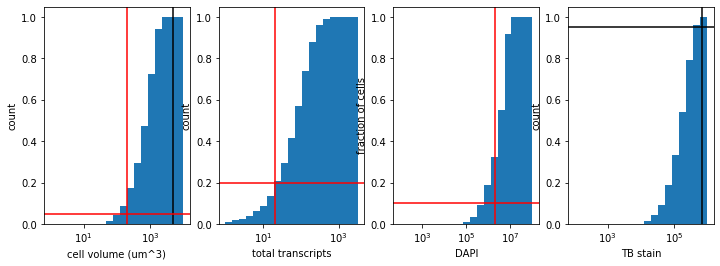

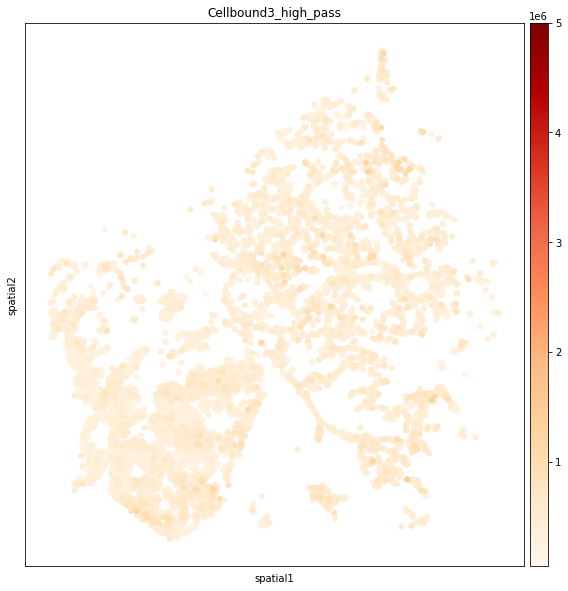

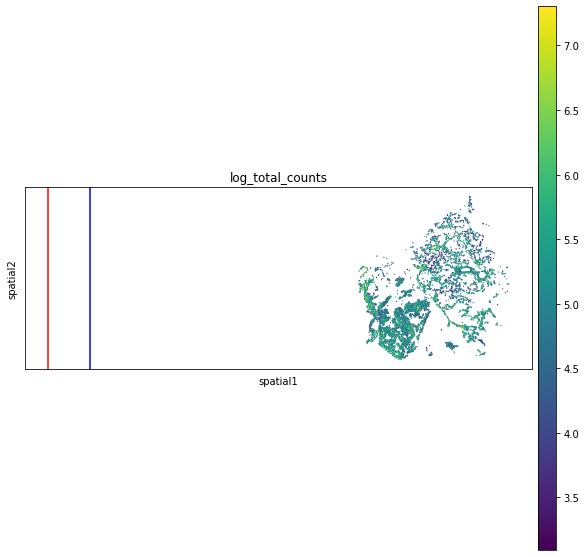

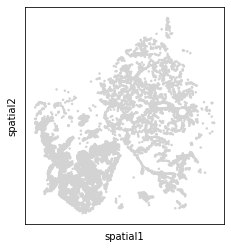

log normalized
scaled
calculating pcs
calculating umap
Scanpy processing complete.
  (0, 2)	1.0
  (0, 3)	1.0
z_level:  0
Dimensions of experiment are 33821 x 39035 in pixels.


100%|██████████| 12312/12312 [00:12<00:00, 952.70it/s] 


z_level:  1
Dimensions of experiment are 33821 x 39035 in pixels.


100%|██████████| 12312/12312 [00:13<00:00, 908.22it/s] 


z_level:  2
Dimensions of experiment are 33821 x 39035 in pixels.


100%|██████████| 12312/12312 [00:13<00:00, 946.74it/s] 


z_level:  3
Dimensions of experiment are 33821 x 39035 in pixels.


100%|██████████| 12312/12312 [00:13<00:00, 918.29it/s] 


z_level:  4
Dimensions of experiment are 33821 x 39035 in pixels.


100%|██████████| 12312/12312 [00:12<00:00, 967.09it/s] 


z_level:  5
Dimensions of experiment are 33821 x 39035 in pixels.


100%|██████████| 12312/12312 [00:12<00:00, 950.10it/s] 


z_level:  6
Dimensions of experiment are 33821 x 39035 in pixels.


100%|██████████| 12312/12312 [00:13<00:00, 898.82it/s]


(8123, 6)
(8123, 6) (8123, 140)
initial thresholding Low     8122
High       1
Name: TB_class_from_images, dtype: int64
with sd cutoff Low     8122
High       1
Name: TB_class_from_images, dtype: int64


100%|██████████| 1/1 [00:00<00:00, 3452.10it/s]


not enough cells to calculate min distance
cells with TB signal above 5 million: (0, 140)


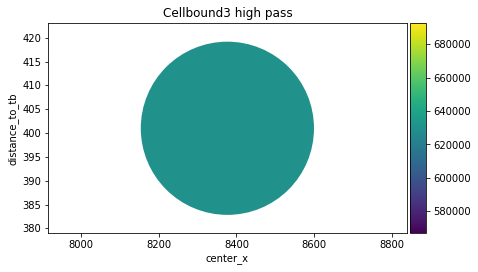

removed super high fluorescent cells Low     8122
High       1
Name: TB_class_from_images, dtype: int64
removed lone cells Low        8122
Removed       1
Name: TB_class_from_images, dtype: int64


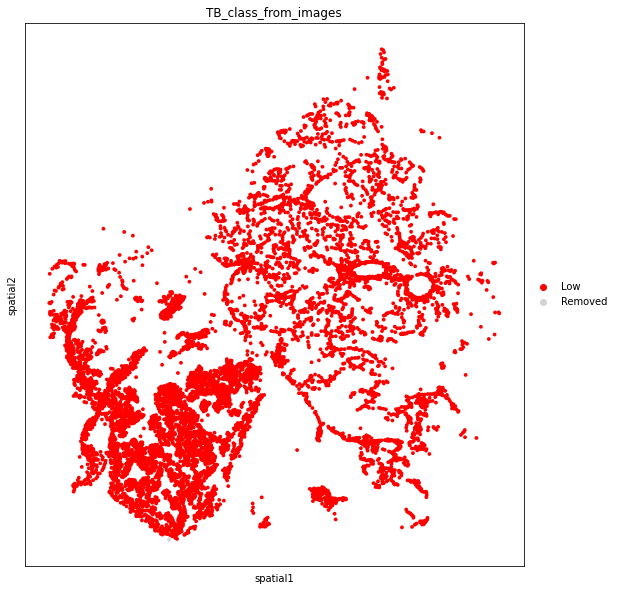

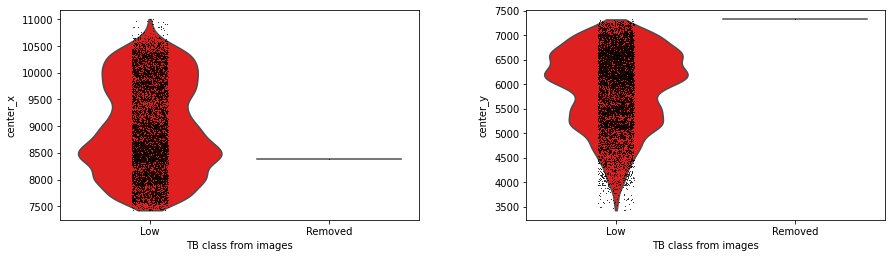

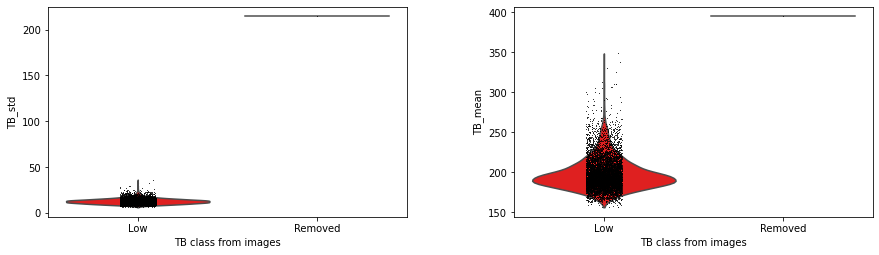

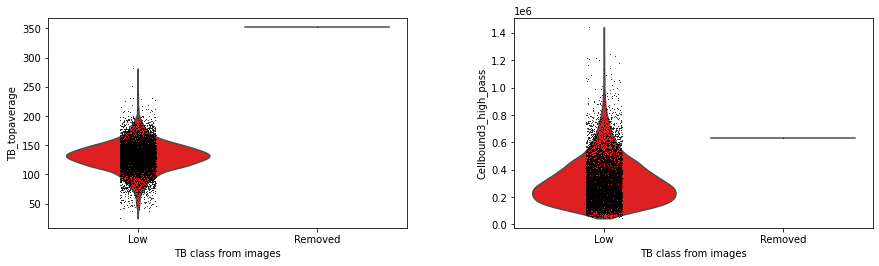

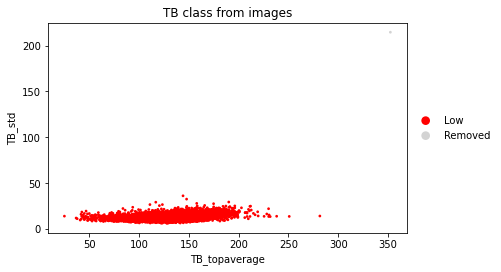

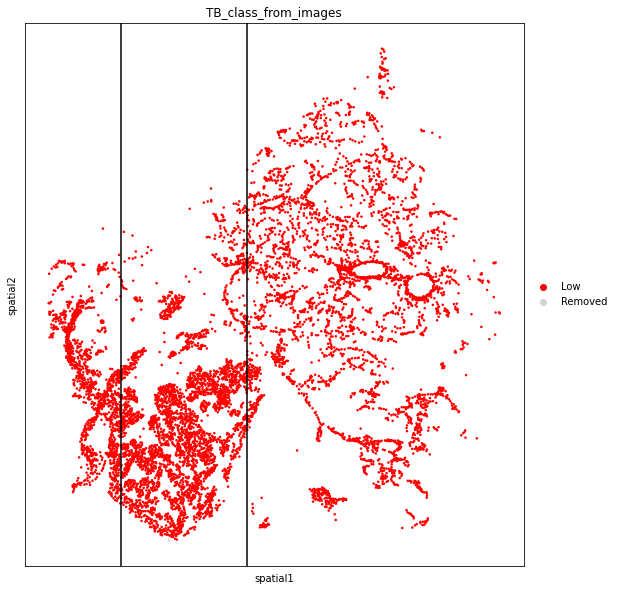

202305231432_TB-CTRL1-MB_VMSC02401 2 0
number of cells in unfiltered dataset:  64788
cells per region:  2    50074
1    12312
0     2402
Name: region, dtype: int64
saving figure
size of adata object:  (50074, 140)
Filtering complete: 39398 cells remaining out of 50074 original cells.


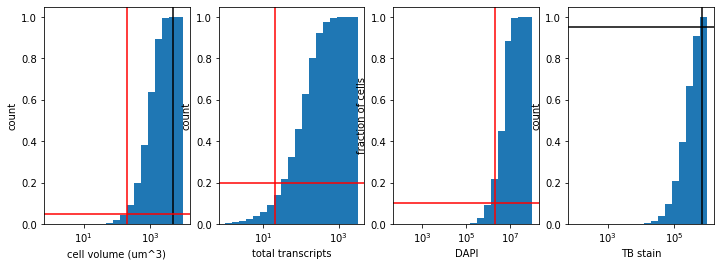

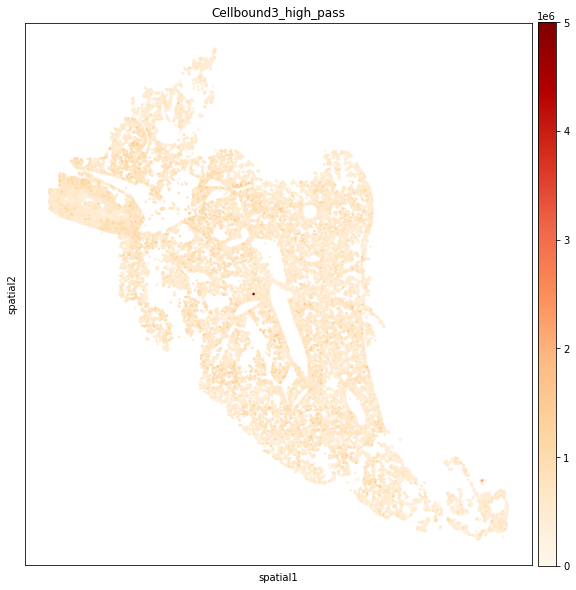

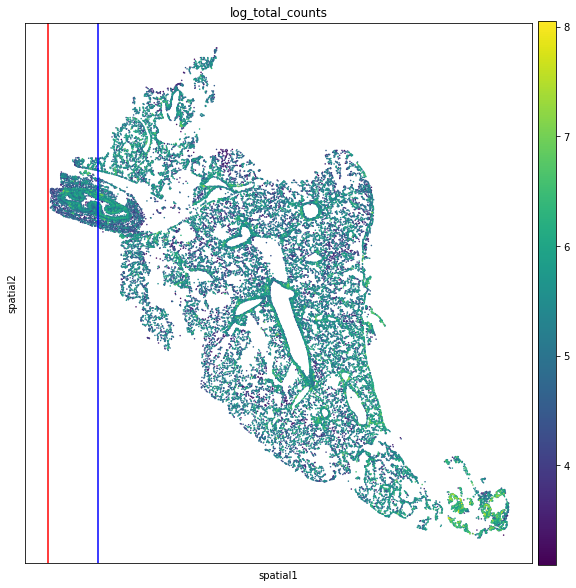

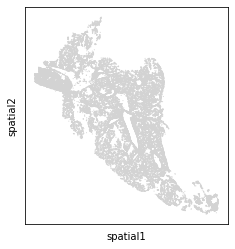

log normalized
scaled
calculating pcs
calculating umap
Scanpy processing complete.
  (0, 0)	7.0
  (0, 1)	22.0
  (0, 2)	2.0
  (0, 3)	5.0
z_level:  0
Dimensions of experiment are 85101 x 89777 in pixels.


100%|██████████| 50074/50074 [00:57<00:00, 875.07it/s] 


z_level:  1
Dimensions of experiment are 85101 x 89777 in pixels.


100%|██████████| 50074/50074 [00:57<00:00, 872.10it/s] 


z_level:  2
Dimensions of experiment are 85101 x 89777 in pixels.


100%|██████████| 50074/50074 [00:57<00:00, 871.58it/s] 


z_level:  3
Dimensions of experiment are 85101 x 89777 in pixels.


100%|██████████| 50074/50074 [00:56<00:00, 880.57it/s] 


z_level:  4
Dimensions of experiment are 85101 x 89777 in pixels.


100%|██████████| 50074/50074 [01:00<00:00, 833.10it/s] 


z_level:  5
Dimensions of experiment are 85101 x 89777 in pixels.


100%|██████████| 50074/50074 [01:00<00:00, 831.10it/s] 


z_level:  6
Dimensions of experiment are 85101 x 89777 in pixels.


100%|██████████| 50074/50074 [01:19<00:00, 633.80it/s]


(39398, 6)
(39398, 6) (39398, 140)
initial thresholding Low     39395
High        3
Name: TB_class_from_images, dtype: int64
with sd cutoff Low     39395
High        3
Name: TB_class_from_images, dtype: int64


100%|██████████| 3/3 [00:00<00:00, 2924.22it/s]


cells with TB signal above 5 million: (1, 140)


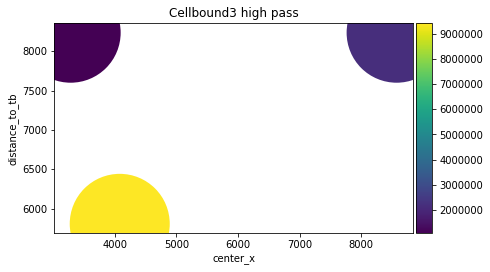

removed super high fluorescent cells Low        39395
High           2
Removed        1
Name: TB_class_from_images, dtype: int64
removed lone cells Low        39395
Removed        3
Name: TB_class_from_images, dtype: int64


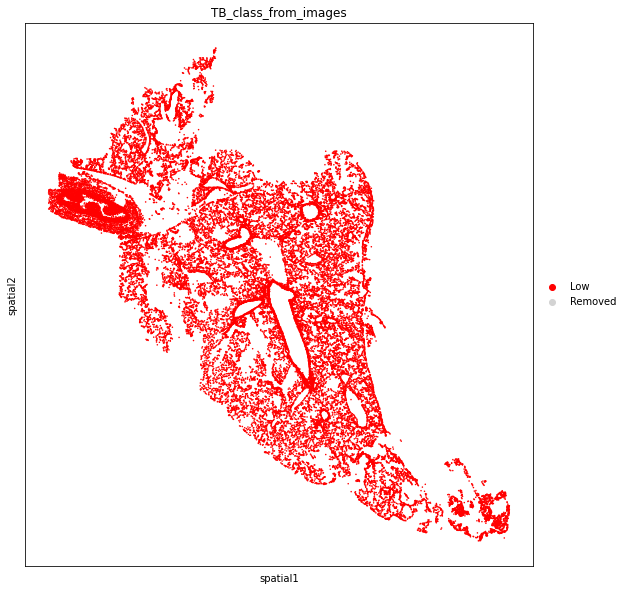

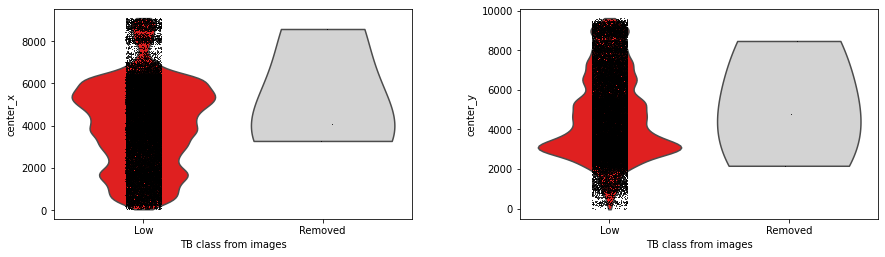

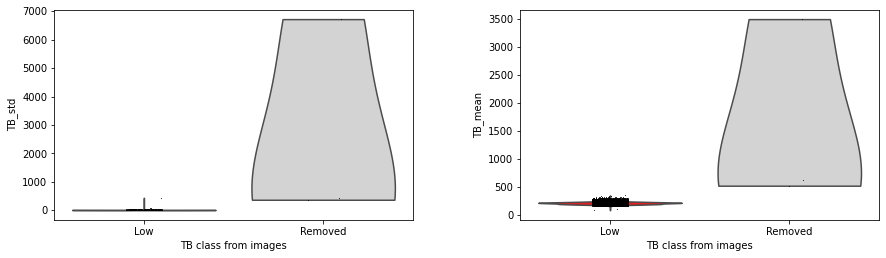

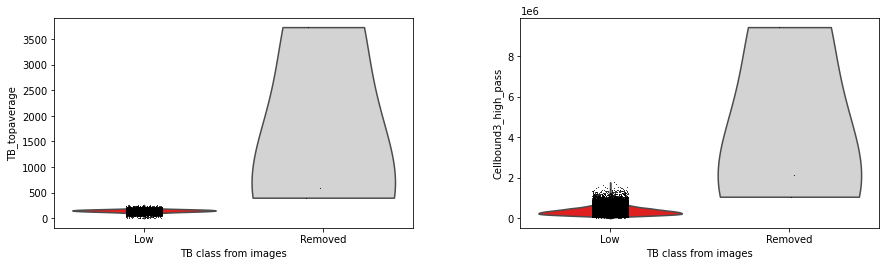

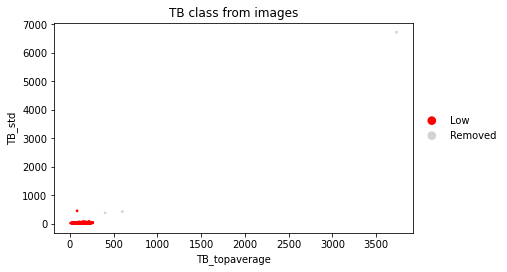

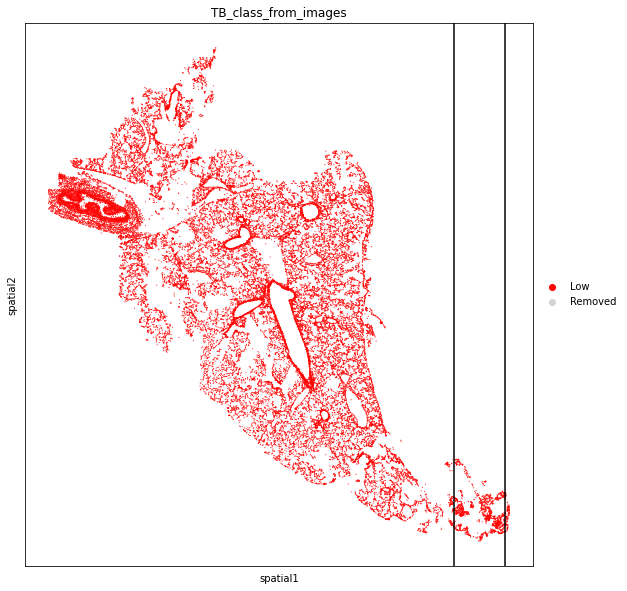

202305251147_TB-CTRL2-MB_VMSC02401 0 0
number of cells in unfiltered dataset:  93038
cells per region:  1    70090
0    22948
Name: region, dtype: int64
saving figure
size of adata object:  (22948, 140)
Filtering complete: 16531 cells remaining out of 22948 original cells.


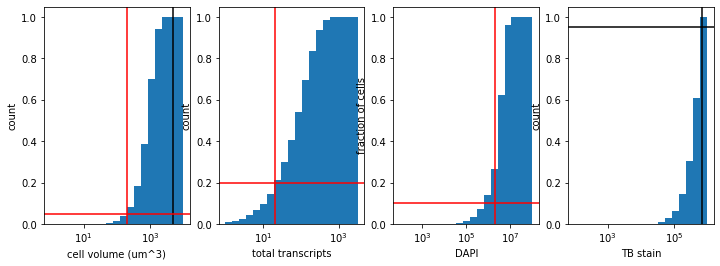

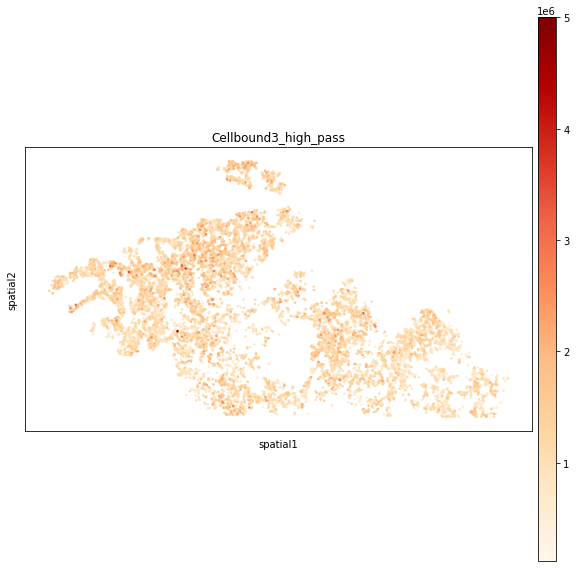

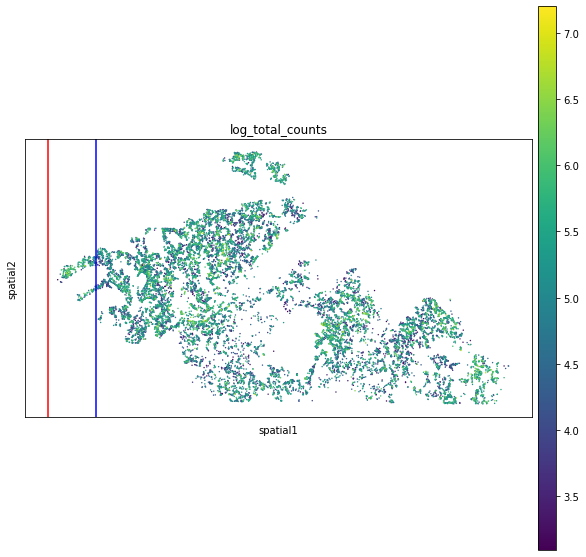

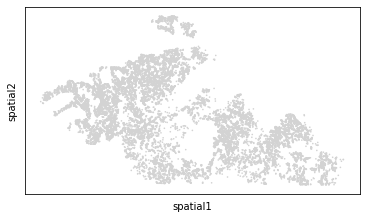

log normalized
scaled
calculating pcs
calculating umap
Scanpy processing complete.
  (0, 0)	6.0
  (0, 1)	1.0
  (0, 2)	2.0
  (0, 3)	8.0
z_level:  0
Dimensions of experiment are 89165 x 48933 in pixels.


100%|██████████| 22948/22948 [00:29<00:00, 785.30it/s] 


z_level:  1
Dimensions of experiment are 89165 x 48933 in pixels.


100%|██████████| 22948/22948 [00:29<00:00, 783.78it/s] 


z_level:  2
Dimensions of experiment are 89165 x 48933 in pixels.


100%|██████████| 22948/22948 [00:30<00:00, 760.32it/s] 


z_level:  3
Dimensions of experiment are 89165 x 48933 in pixels.


100%|██████████| 22948/22948 [00:30<00:00, 761.27it/s] 


z_level:  4
Dimensions of experiment are 89165 x 48933 in pixels.


100%|██████████| 22948/22948 [00:29<00:00, 789.56it/s] 


z_level:  5
Dimensions of experiment are 89165 x 48933 in pixels.


100%|██████████| 22948/22948 [00:29<00:00, 789.52it/s] 


z_level:  6
Dimensions of experiment are 89165 x 48933 in pixels.


100%|██████████| 22948/22948 [00:28<00:00, 808.00it/s]


(16531, 6)
(16531, 6) (16531, 140)
initial thresholding High    13319
Low      3212
Name: TB_class_from_images, dtype: int64
with sd cutoff Removed    13308
Low         3212
High          11
Name: TB_class_from_images, dtype: int64


100%|██████████| 11/11 [00:00<00:00, 1882.08it/s]


cells with TB signal above 5 million: (1, 140)


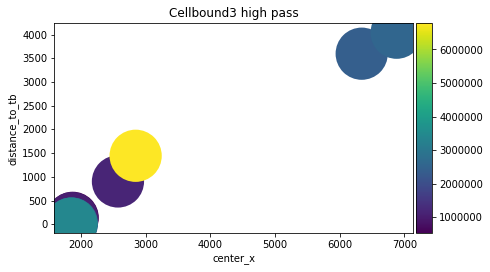

removed super high fluorescent cells Removed    13309
Low         3212
High          10
Name: TB_class_from_images, dtype: int64
removed lone cells Removed    13312
Low         3212
High           7
Name: TB_class_from_images, dtype: int64


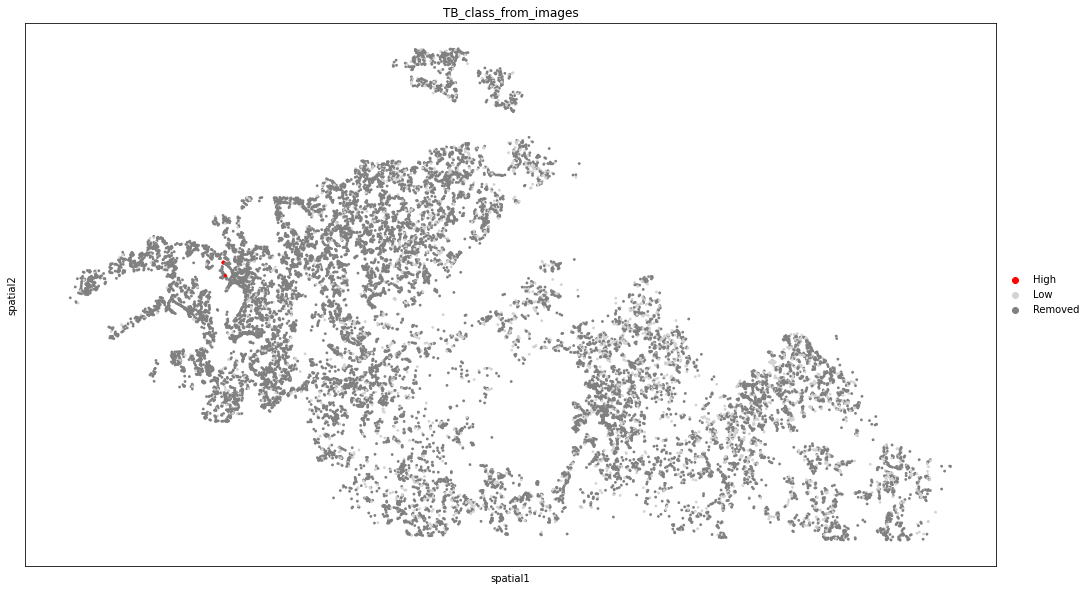

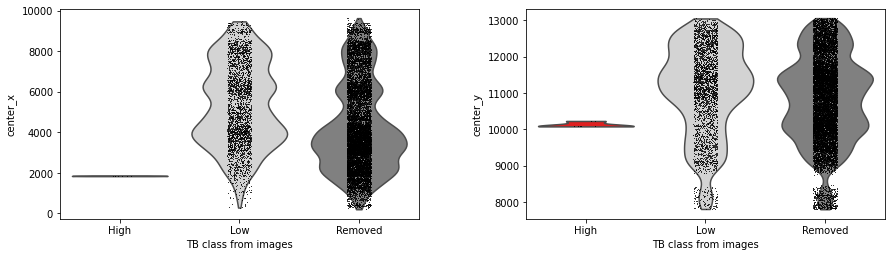

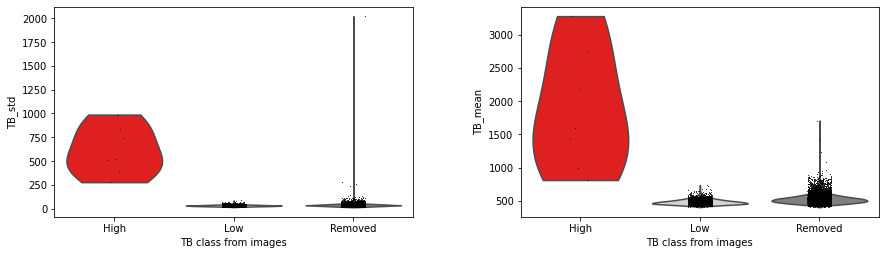

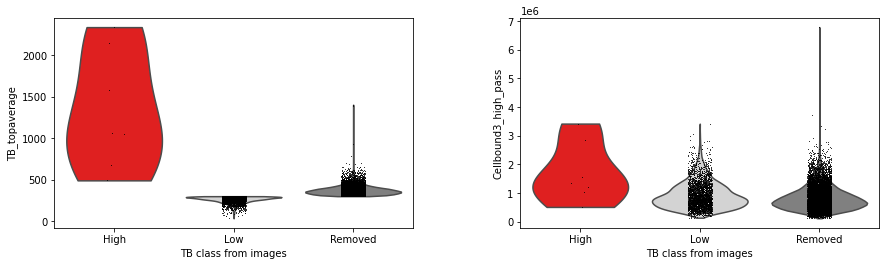

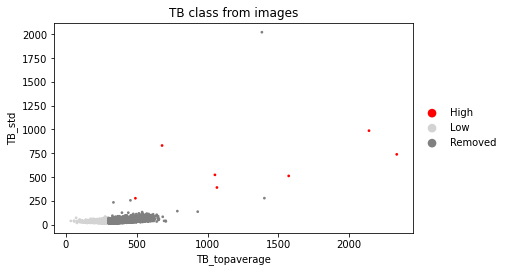

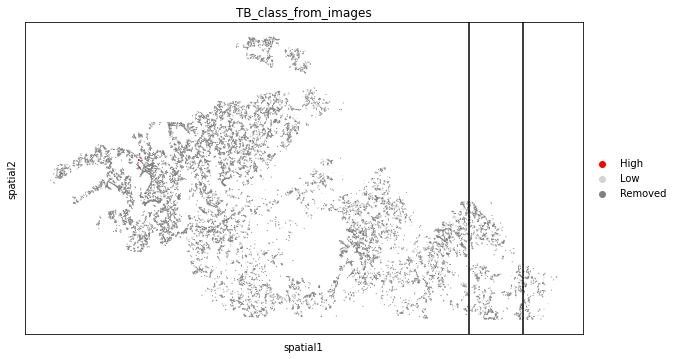

100%|██████████| 16531/16531 [00:06<00:00, 2377.17it/s]


number of cells per bin:  Null    15395
Bin7      394
Bin4      252
Bin3      210
Bin2      183
Bin1       90
Bin0        7
Name: Bin, dtype: int64


100%|██████████| 140/140 [1:40:30<00:00, 43.07s/it]


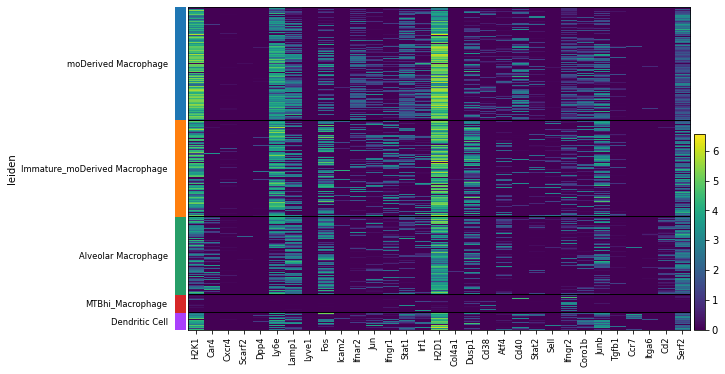

up near TB:  2 
down near TB: 31


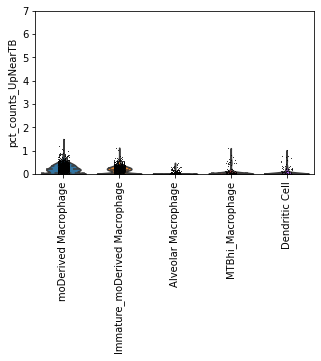

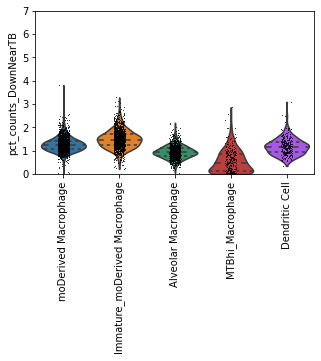

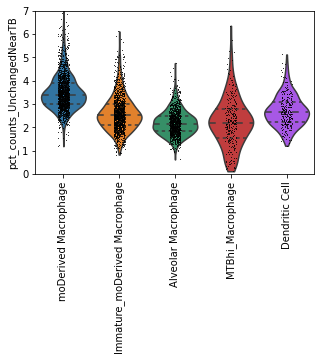

0.0001
202305261458_TB-TEST3-MB_VMSC02401 1 2000
number of cells in unfiltered dataset:  54560
cells per region:  1    41971
0    12589
Name: region, dtype: int64
saving figure
size of adata object:  (41971, 140)
Filtering complete: 25660 cells remaining out of 41971 original cells.


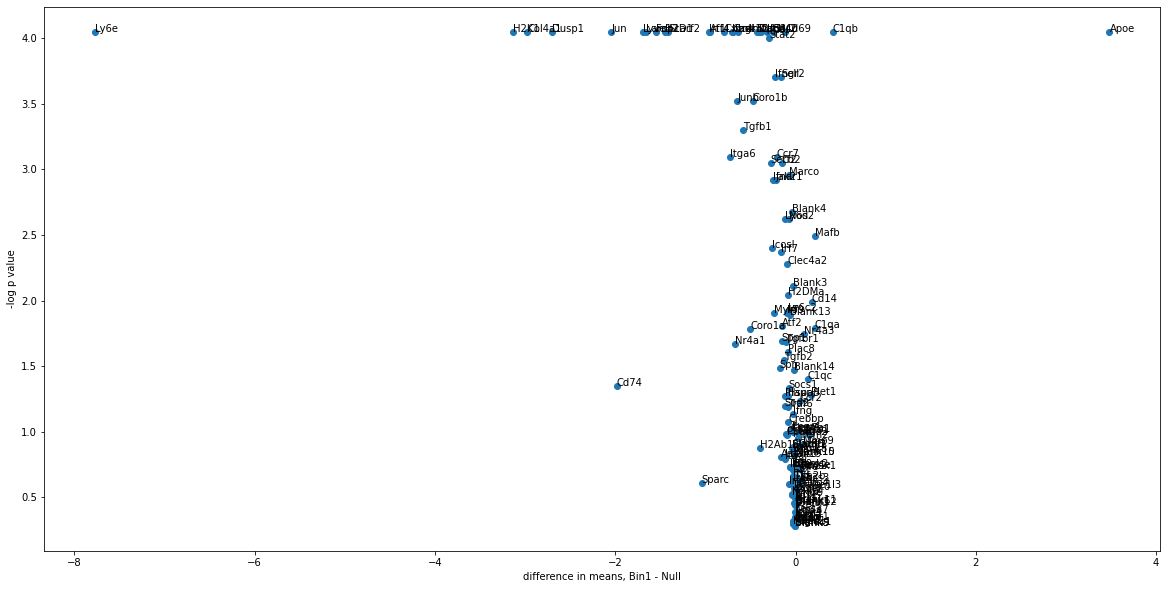

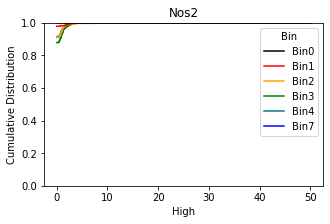

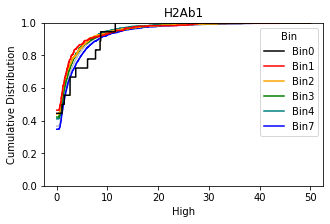

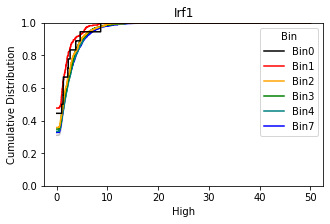

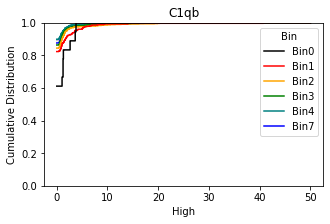

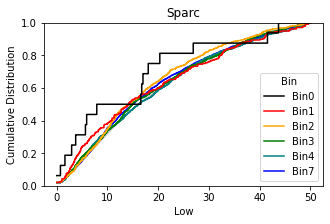

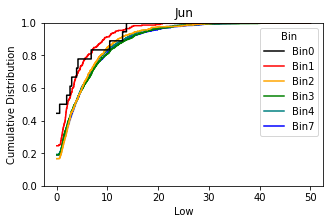

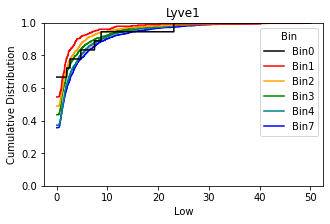

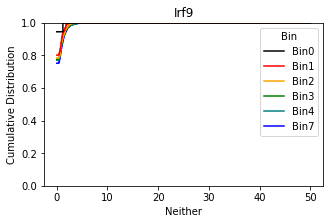

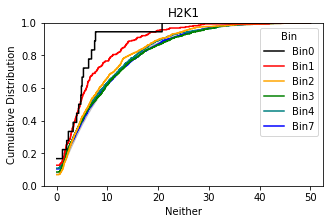

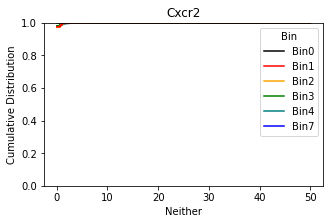

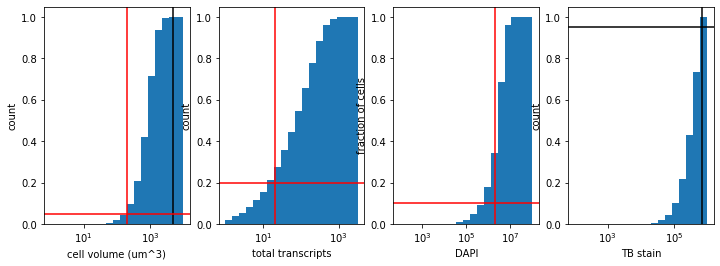

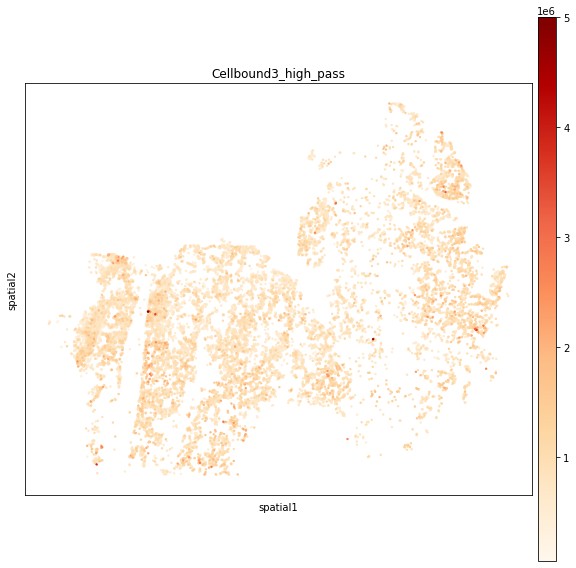

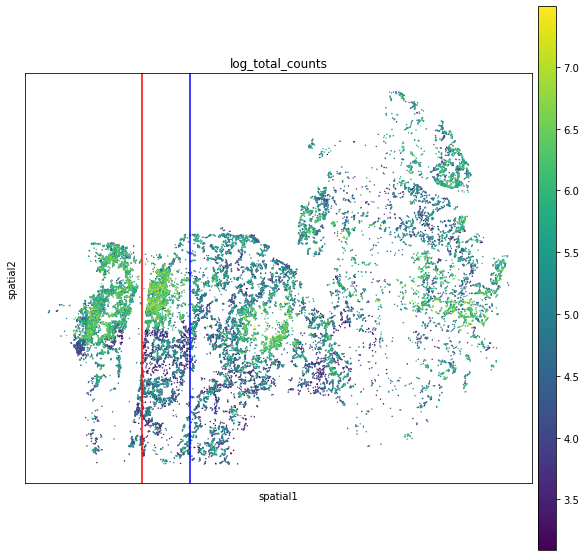

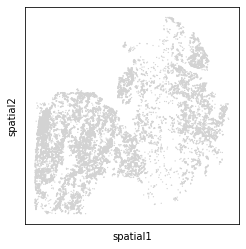

log normalized
scaled
calculating pcs
calculating umap
Scanpy processing complete.
  (0, 1)	4.0
  (0, 2)	4.0
  (0, 3)	3.0
z_level:  0
Dimensions of experiment are 89572 x 72495 in pixels.


100%|██████████| 41971/41971 [00:51<00:00, 813.44it/s] 


z_level:  1
Dimensions of experiment are 89572 x 72495 in pixels.


100%|██████████| 41971/41971 [00:49<00:00, 841.78it/s] 


z_level:  2
Dimensions of experiment are 89572 x 72495 in pixels.


100%|██████████| 41971/41971 [00:52<00:00, 798.44it/s] 


z_level:  3
Dimensions of experiment are 89572 x 72495 in pixels.


100%|██████████| 41971/41971 [00:50<00:00, 837.57it/s] 


z_level:  4
Dimensions of experiment are 89572 x 72495 in pixels.


100%|██████████| 41971/41971 [00:55<00:00, 761.90it/s] 


z_level:  5
Dimensions of experiment are 89572 x 72495 in pixels.


100%|██████████| 41971/41971 [00:54<00:00, 768.66it/s] 


z_level:  6
Dimensions of experiment are 89572 x 72495 in pixels.


100%|██████████| 41971/41971 [01:01<00:00, 681.61it/s]


(19915, 6)
(19915, 6) (19915, 140)
initial thresholding Low     13074
High     6841
Name: TB_class_from_images, dtype: int64
with sd cutoff Low        13074
Removed     6763
High          78
Name: TB_class_from_images, dtype: int64


100%|██████████| 78/78 [00:00<00:00, 370.57it/s]


cells with TB signal above 5 million: (1, 140)


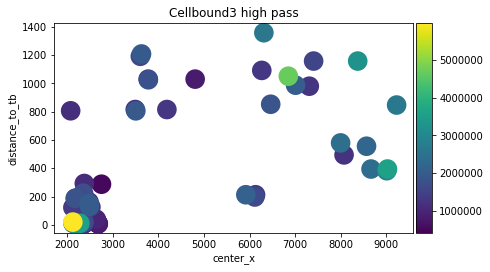

removed super high fluorescent cells Low        13074
Removed     6764
High          77
Name: TB_class_from_images, dtype: int64
removed lone cells Low        13074
Removed     6785
High          56
Name: TB_class_from_images, dtype: int64
Removed    15448
Low         4417
High          50
Name: TB_class_from_images, dtype: int64


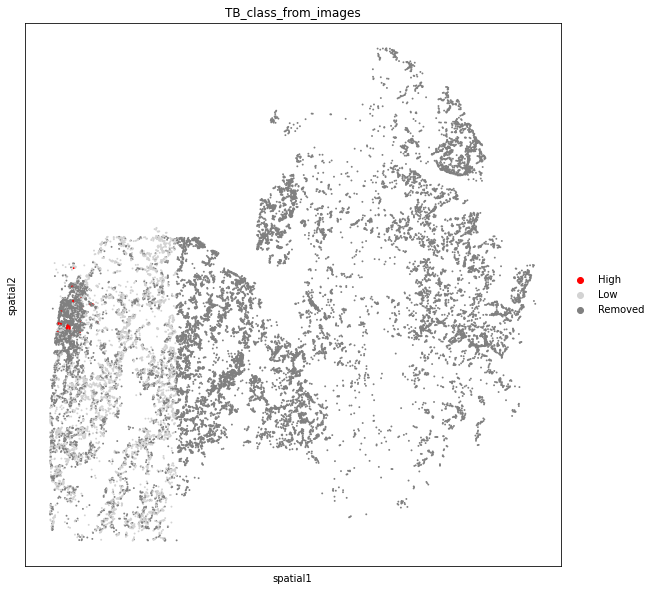

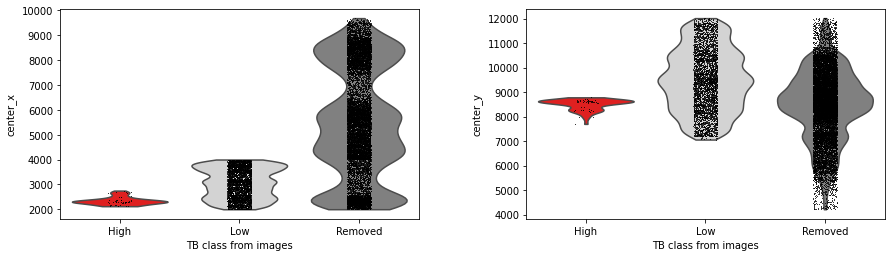

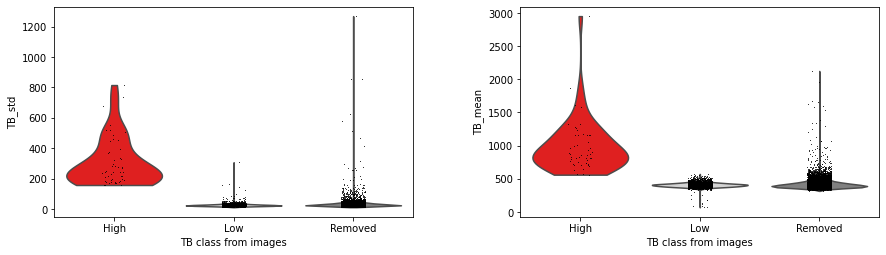

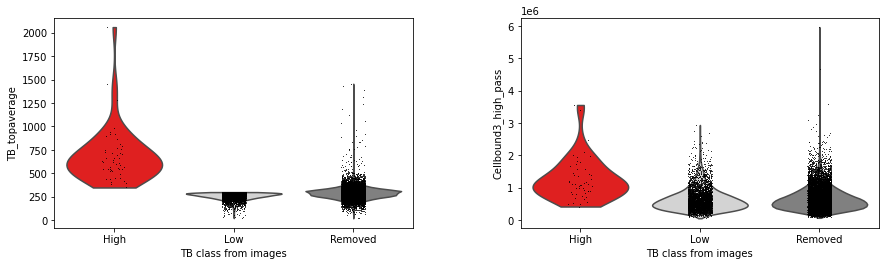

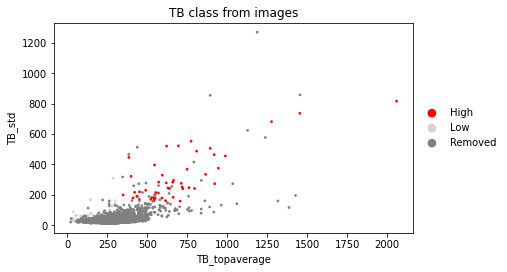

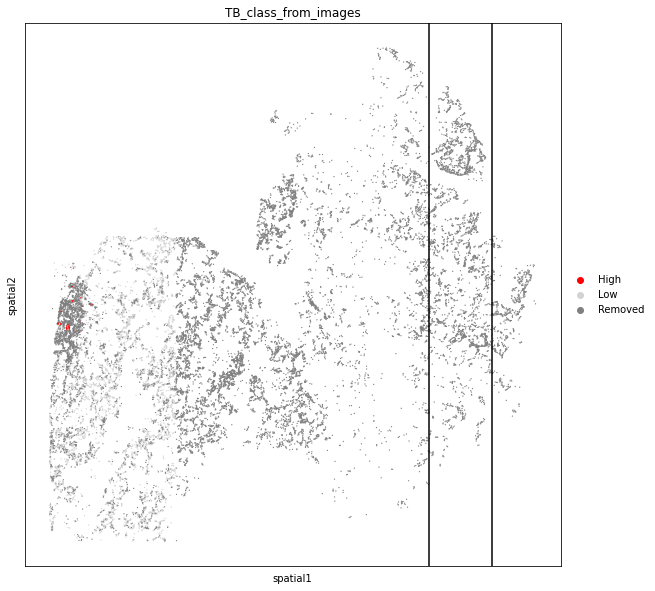

100%|██████████| 19915/19915 [00:36<00:00, 551.92it/s]


number of cells per bin:  Null    17089
Bin1     1249
Bin2      745
Bin7      294
Bin4      285
Bin3      203
Bin0       50
Name: Bin, dtype: int64


 85%|████████▌ | 119/140 [34:38<06:06, 17.45s/it]

In [ ]:
import warnings
warnings.filterwarnings('ignore')

for jloc in experiment_df.index:
    experimentName = experiment_df.experimentName[jloc]
    region = experiment_df.region[jloc]
    clipx = experiment_df.clipx[jloc]
    print(experimentName, region, clipx)

    filenames = os.listdir(processedDataPath+experimentName)
    filename = [i for i in filenames if i.endswith('.h5ad')][0]
    
    ## Process the vizgen adata file and filter out damaged tissue
    adata = load_vizgen_h5ad(processedDataPath = processedDataPath,experimentName=experimentName, filename = filename, region=region,
                    min_volume=200, max_volume=5000, min_counts=20, min_dapi = 2000000, TB_threshold = 700000)
    adata = filter_h5ad(adata)
    show_spatial_plots(adata,clipx, experimentName,region)

    #remove any damage
    adata = adata[adata.obs.center_x>clipx].copy()
    if experimentName == '202309251210_20230925-RitwicqA-TB_VMSC02401' and region=='1':
        adata = adata[adata.obs.center_y<6500].copy()
    sc.pl.spatial(adata,spot_size=50)
    adata = sc_preprocess(adata)
    
    ## Load in the image data and calculate metrics for each segment using the antibody information
    
    #collect data from images
    df = load_tb_image_information(dataPath=dataPath,experimentName=experimentName,region=region)
    #calculate average signal per cell for each metric
    avg_signal_df = make_average_gdf(df,adata)
    print(avg_signal_df.shape, adata.shape)

    #Define TB positive cells
    adata = assign_tb_pos_cells(adata,avg_signal_df, threshold,std_threshold,experimentName, region)

    #normalize count data to polyA signal per cell
    adata.layers['normalized_to_polyT'] = adata.layers['counts']/np.array(adata.obs.PolyT_high_pass).reshape(-1,1)*np.mean(adata.obs.PolyT_high_pass)
    adata.layers['normalized_to_polyT'] = sparse.csr_matrix(adata.layers['normalized_to_polyT'])
        
    #skip these parts if there are not TB+ cells
    if 'High' in set(adata.obs.TB_class_from_images):
        
        adata = calculate_distance_to_tb(adata)
        adata.obs.distance_to_tb = adata.obs.distance_to_tb.astype('float')

        adata_df, df_results = permutation_test_for_tb_loc(adata,layer=layer,binsize=binsize,perm_iterations=perm_iterations)
        sc_data = plot_tb_altered_transcripts(sc_data,pval_threshold, stat_threshold, df_results,experimentName, region,perm_iterations)

        plot_cumulative_dist(marker_dict,adata_df,experimentName,region,ymax=50)
    adata.write_h5ad(dataPath+'Annotated_h5ad/'+experimentName+'_region'+str(region)+'_Annotated.h5ad')
    gc.collect()

### 1. Plotting per-replicate values for each target transcript (Figure 6c)

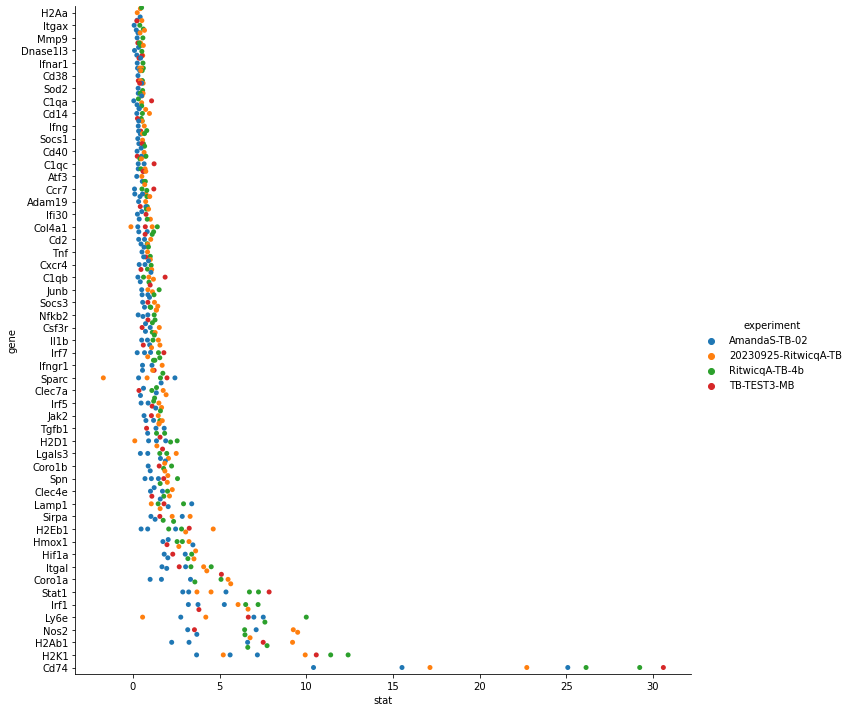

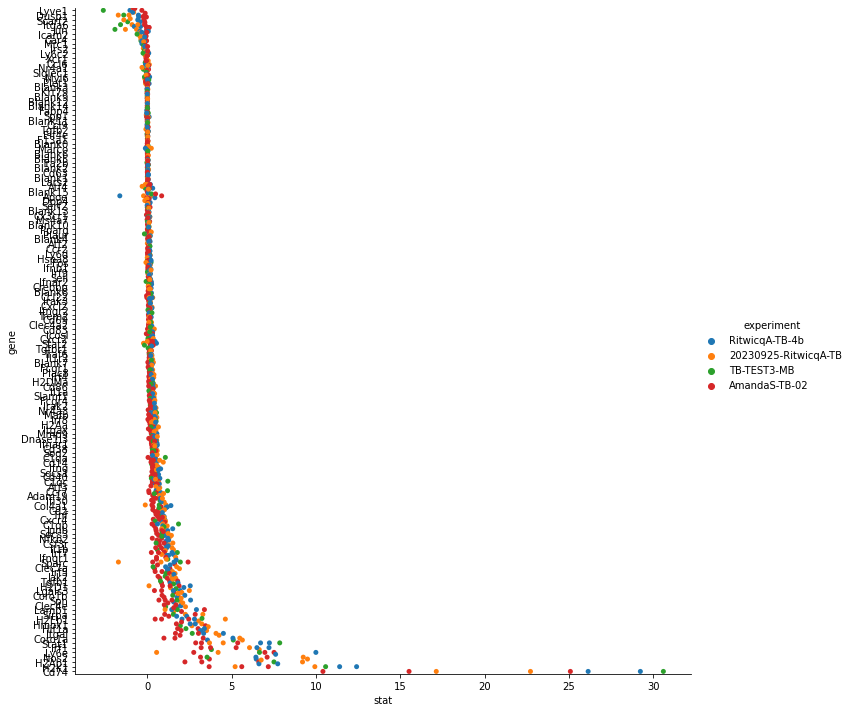

In [54]:
#load in final df_results and find consensus genes, plot top ones with a dot for each replicate, show consensus on violin plots for smartseq data
#for cumulative distribution plots, show on total dataset

#1. make a file with all the genes and all the data points
folder = dataPath+'Stats/'

df = pd.DataFrame(columns = ['gene','stat','p_value','experiment','region'])

for file in os.listdir(folder):
    if not file.endswith('.csv'):
        continue
        
    #use only the TB files
    if 'CTRL' in file:
        continue
    if 'All' in file:
        continue
    if 'Total' in file:
        continue
    experiment = file.split('_')[1]
    region = file.split('_')[3].split('.')[0]
    
    stats = pd.read_csv(folder+file)
    stats.columns = ['gene','stat','remove','p_value']
    del stats['remove']
    stats['experiment'] = experiment
    stats['region'] = region

    df = pd.concat([df, stats],ignore_index=True)

#plot each gene using a swarmplot
average_df = pd.DataFrame(columns=['average'])
for gene in list(set(df.gene)):
    mean = np.mean(df.loc[df.gene==gene].stat)
    average_df.loc[gene] = mean
    
average_df = average_df.sort_values('average')
gene_list = list(average_df.index)

df['average_value'] = 0
for gene in average_df.index:
    df.loc[df.gene==gene,'average_value']=average_df.loc[gene,'average']
df
df = df.sort_values('average_value')
df.p_value[df.p_value>0.0001] = 0.1
df.p_value[df.p_value<0.0001] = 0.0001
df.p_value.value_counts()

df.to_csv(dataPath+'Stats/statsAllTB_individualReplicates-excludingTB.csv')
ax = sns.catplot(data=df.iloc[700:1125], 
                 x="stat", 
                 y="gene", 
                 hue="experiment", 
                 #palette = ['red','orange','lightgrey'],
                 kind="swarm",
                 aspect=1,
                 height=10,
                 row_order=gene_list)
plt.savefig(dataPath+"Figures/replicate_samplestat_experiment_last700samples-excludingtb.pdf", format='pdf')
plt.show()



ax = sns.catplot(data=df, 
                 x="stat", 
                 y="gene", 
                 hue="experiment", 
                 #palette = ['red','orange','lightgrey'],
                 kind="swarm",
                 aspect=1,
                 height=10,
                 row_order=gene_list)

plt.savefig(dataPath+"Figures/replicate_samplestat_experiment-withoutTBcells.pdf", format='pdf')
plt.show()

### 2. Find genes that are up-, down-, and unregulated by proximity to TB (Figure 6d)

In [55]:
average_df

#from kruskal-wallis test (for upregulated genes) p<0.01 compared to all the blanks, 
#carried out in prism using the statsAllTB_individualReplicates-excludingTB.csv file created above

low_markers = list(average_df.loc[average_df.average< -0.2].index)
print(low_markers)
high_markers = ['Ifng','Socs1','Cd40','C1qc','Atf3','Ifi30','Adam19','Cd2','Tnf','Cxcr4','C1qb','Junb','Socs3',
                'Nfkb2','Csf3r','Il1b','Irf7','Ifngr1','Sparc','Clec7a','Irf5','Jak2','Tgfb1','H2D1','Lgals3',
                'Coro1b','Spn','Clec4e','Lamp1','Sirpa','H2Eb1','Hmox1','Hif1a','Itgal','Coro1a','Stat1','Irf1','Ly6e','Nos2','H2Ab1',
                'H2K1','Cd74']


neither = [x for x in list(average_df.index) if x not in low_markers+high_markers]
neither = [x for x in neither if not x.startswith('Blank')]

heatmap_labels = {'Up':high_markers,'Down':low_markers}
heatmap_labels

['Lyve1', 'Dusp1', 'Scarf2', 'Itga6', 'Jun', 'Icam2', 'Car4']


{'Up': ['Ifng',
  'Socs1',
  'Cd40',
  'C1qc',
  'Atf3',
  'Ifi30',
  'Adam19',
  'Cd2',
  'Tnf',
  'Cxcr4',
  'C1qb',
  'Junb',
  'Socs3',
  'Nfkb2',
  'Csf3r',
  'Il1b',
  'Irf7',
  'Ifngr1',
  'Sparc',
  'Clec7a',
  'Irf5',
  'Jak2',
  'Tgfb1',
  'H2D1',
  'Lgals3',
  'Coro1b',
  'Spn',
  'Clec4e',
  'Lamp1',
  'Sirpa',
  'H2Eb1',
  'Hmox1',
  'Hif1a',
  'Itgal',
  'Coro1a',
  'Stat1',
  'Irf1',
  'Ly6e',
  'Nos2',
  'H2Ab1',
  'H2K1',
  'Cd74'],
 'Down': ['Lyve1', 'Dusp1', 'Scarf2', 'Itga6', 'Jun', 'Icam2', 'Car4']}

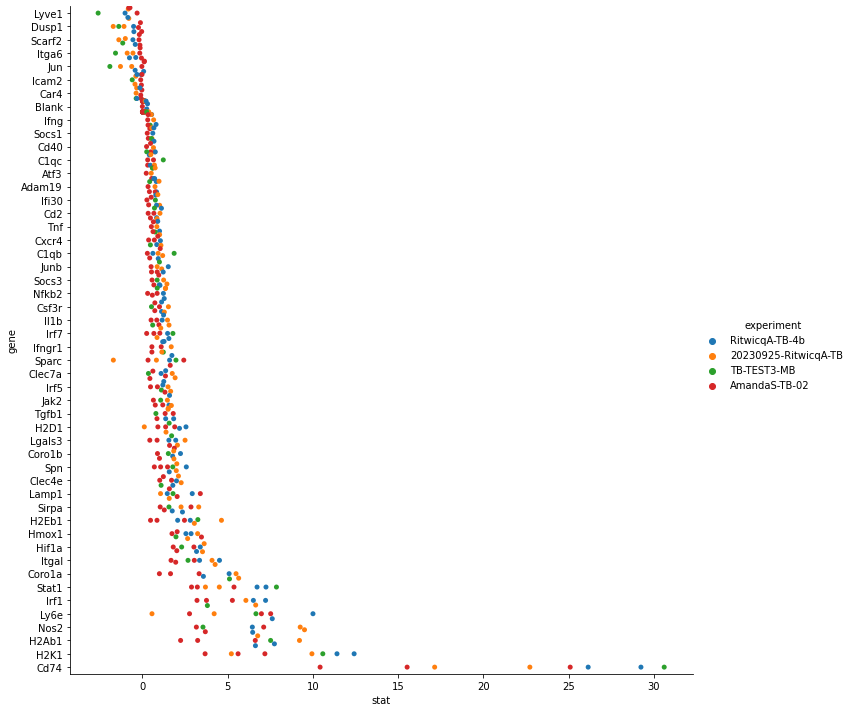

In [56]:
df_new = df.copy()
df_new.loc[df_new.gene.str.startswith("Blank"),'gene']='Blank'
df_new = df_new.loc[~df_new.gene.isin(neither)]
df_new

ax = sns.catplot(data=df_new, 
                 x="stat", 
                 y="gene", 
                 hue="experiment", 
                 #palette = ['red','orange','lightgrey'],
                 kind="swarm",
                 aspect=1,
                 height=10,
                 row_order=gene_list)

plt.savefig(dataPath+"Figures/replicate_samplestat_experiment-withoutTBcells.pdf", format='pdf')
plt.show()

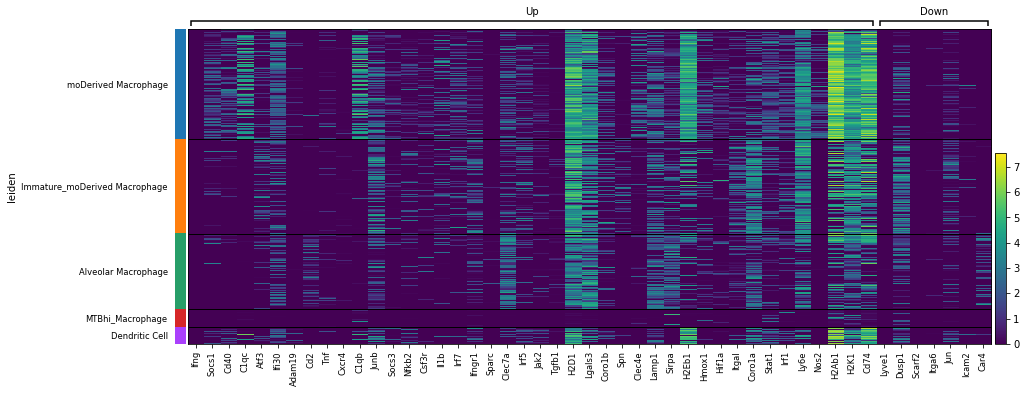

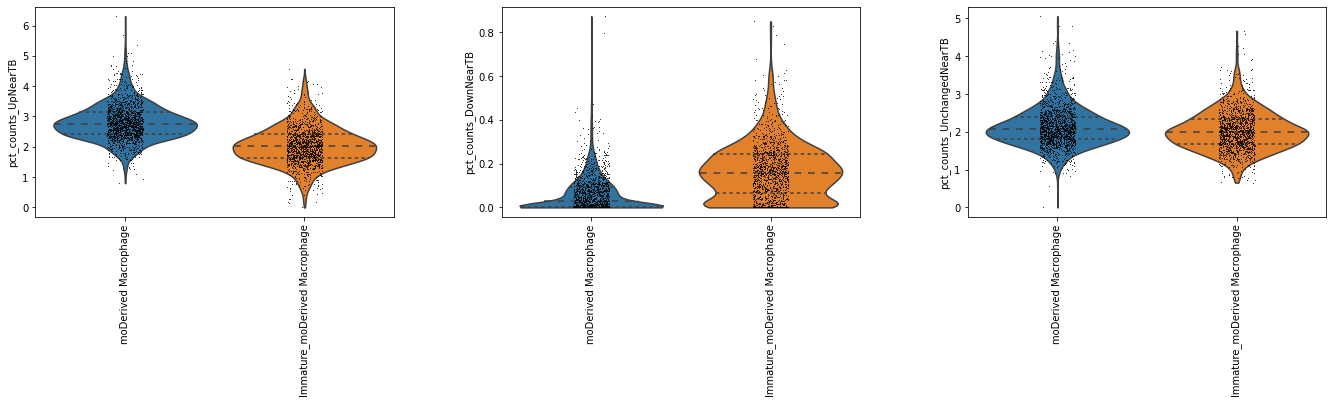

In [72]:
#print a heatmap
sc.pl.heatmap(sc_data,var_names = heatmap_labels, groupby='leiden',show_gene_labels=True,save = 'tbfinal_cleanmarkers.pdf')

sc_data.var['UpNearTB']=False
sc_data.var['UnchangedNearTB']=False
sc_data.var['DownNearTB']=False

sc_data.var.loc[high_markers,'UpNearTB']=True
sc_data.var.loc[low_markers,'DownNearTB']=True
sc_data.var.loc[neither,'UnchangedNearTB']=True
sc.pp.calculate_qc_metrics(sc_data,qc_vars = ['UpNearTB','DownNearTB','UnchangedNearTB'],percent_top=None,inplace=True,log1p=False)
sc.pl.violin(sc_data[sc_data.obs.leiden.isin(['moDerived Macrophage','Immature_moDerived Macrophage'])],['pct_counts_UpNearTB','pct_counts_DownNearTB','pct_counts_UnchangedNearTB'],
             groupby='leiden',rotation=90,inner='quartile', save ='TB_affected_counts_violin.pdf')

### 3. Combine all replicates into one merged h5ad

In [73]:
#load all the h5ads and merge them into one object, re-normalize

folder = dataPath

adata = concatenate_h5ad_folder(input_folder=folder+'Annotated_h5ad',
                            output_folder=folder,
                            name = 'concatenated_vizgen_h5ad',
                            regex = ['date','slide','project','region'],
                            regex_sep = '_',
                            counts_threshold=0,
                            genes_threshold=0,
                            adata_file = 'None',
                            save_frequency = 100)

print(adata.obs['slide'].value_counts())

adata.obs['Condition'] = 'Control'
adata.obs.loc[~adata.obs.slide.isin(['TB-CTRL2-MB','TB-CTRL1-MB']),'Condition']='TB'
print(adata.obs.groupby(['Condition','slide'])['fov'].count())

adata.obs['genomics_personnel'] = 'Michael_Borja'
adata.obs.loc[adata.obs.slide.str.startswith('Amanda'),'genomics_personnel'] = 'Amanda_Seng'
adata.obs.loc[adata.obs.slide.str.startswith('Ritwicq'),'genomics_personnel'] = 'Ritwicq_Arjyal'
adata.obs.loc[adata.obs.slide.str.startswith('20230925'),'genomics_personnel'] = 'Ritwicq_Arjyal'

adata.obs['experiment_name'] = 'Control_1'
adata.obs.loc[adata.obs.slide.str.startswith('20230925'),'experiment_name'] = 'TB_Mouse2_SectionA'
adata.obs.loc[adata.obs.slide.str.startswith('Ritwicq'),'experiment_name'] = 'TB_Mouse4_SectionB'
adata.obs.loc[adata.obs.slide.str.startswith('Amanda'),'experiment_name'] = 'TB_Mouse4_SectionC'
adata.obs.loc[adata.obs.slide.str.startswith('TB-TEST3'),'experiment_name'] = 'TB_MouseX_Test3'
adata.obs.loc[adata.obs.slide.str.startswith('TB-CTRL2'),'experiment_name'] = 'Ctrl_MouseX_Exp2'
adata.obs.loc[adata.obs.slide.str.startswith('TB-CTRL1'),'experiment_name'] = 'Ctrl_MouseX_Exp1'

print(adata.obs.experiment_name.value_counts())

adata.obs['full_sample'] = adata.obs.experiment_name.astype('str')+'_'+adata.obs.region.astype('str')
adata.obs.full_sample.value_counts()

adata.obs.PolyT_high_pass = adata.obs.PolyT_high_pass.astype('float')
adata.layers['normalized_to_polyT'] = adata.layers['counts']/np.array(adata.obs.PolyT_high_pass).reshape(-1,1)*np.mean(adata.obs.PolyT_high_pass)
adata.layers['normalized_to_polyT'] = sparse.csr_matrix(adata.layers['normalized_to_polyT'])
       
    
adata.obs.distance_to_tb = adata.obs.distance_to_tb.astype('float')
adata.obs['grouped_distance_to_tb'] = '1_far'
adata.obs.loc[adata.obs.distance_to_tb<1000,'grouped_distance_to_tb'] = '2_within_1_mm'
adata.obs.loc[adata.obs.distance_to_tb<100,'grouped_distance_to_tb'] = '3_within_100_um'
adata.obs.loc[adata.obs.distance_to_tb==0,'grouped_distance_to_tb'] = '4_TBPositive'
adata.obs.loc[adata.obs.distance_to_tb<-1,'grouped_distance_to_tb'] = '5_Unclear'

adata.obs.grouped_distance_to_tb.value_counts()
adata.var.index = [i.replace("-","") for i in adata.var.index]

#save this object with all the columns

adata.write_h5ad(folder+'Total_annotated_vizgen_TB_20231120.h5ad')

adata_keep = adata.copy()

first file:  202310091253_AmandaS-TB-02_VMSC02401_region2_Annotated.h5ad


  0%|          | 0/15 [00:00<?, ?it/s]

reading  202310091253_AmandaS-TB-02_VMSC02401_region2_Annotated.h5ad
adding .obs columns to anndata object
copying interim


  7%|▋         | 1/15 [00:01<00:20,  1.43s/it]

reading  202305251147_TB-CTRL2-MB_VMSC02401_region0_Annotated.h5ad
adding .obs columns to anndata object
added to adata


 20%|██        | 3/15 [00:02<00:09,  1.32it/s]

reading  202309251210_20230925-RitwicqA-TB_VMSC02401_region2_Annotated.h5ad
adding .obs columns to anndata object
added to adata


 27%|██▋       | 4/15 [00:03<00:09,  1.10it/s]

reading  202310111428_RitwicqA-TB-4b_VMSC02401_region2_Annotated.h5ad
adding .obs columns to anndata object
added to adata


 33%|███▎      | 5/15 [00:07<00:19,  1.95s/it]

reading  202305231432_TB-CTRL1-MB_VMSC02401_region1_Annotated.h5ad
adding .obs columns to anndata object
added to adata


 40%|████      | 6/15 [00:08<00:14,  1.65s/it]

reading  202305231432_TB-CTRL1-MB_VMSC02401_region0_Annotated.h5ad
adding .obs columns to anndata object
added to adata


 47%|████▋     | 7/15 [00:09<00:10,  1.37s/it]

reading  202310091253_AmandaS-TB-02_VMSC02401_region0_Annotated.h5ad
adding .obs columns to anndata object
added to adata


 53%|█████▎    | 8/15 [00:10<00:08,  1.24s/it]

reading  202309251210_20230925-RitwicqA-TB_VMSC02401_region1_Annotated.h5ad
adding .obs columns to anndata object
added to adata


 60%|██████    | 9/15 [00:12<00:08,  1.43s/it]

reading  202310091253_AmandaS-TB-02_VMSC02401_region1_Annotated.h5ad
adding .obs columns to anndata object
added to adata


 67%|██████▋   | 10/15 [00:15<00:09,  1.83s/it]

reading  202305261458_TB-TEST3-MB_VMSC02401_region1_Annotated.h5ad
adding .obs columns to anndata object
added to adata


 73%|███████▎  | 11/15 [00:16<00:07,  1.76s/it]

reading  202305231432_TB-CTRL1-MB_VMSC02401_region2_Annotated.h5ad
adding .obs columns to anndata object
added to adata


 80%|████████  | 12/15 [00:19<00:06,  2.03s/it]

reading  202305251147_TB-CTRL2-MB_VMSC02401_region1_Annotated.h5ad
adding .obs columns to anndata object
added to adata


 93%|█████████▎| 14/15 [00:21<00:01,  1.67s/it]

reading  202310111428_RitwicqA-TB-4b_VMSC02401_region1_Annotated.h5ad
adding .obs columns to anndata object
added to adata


100%|██████████| 15/15 [00:24<00:00,  1.62s/it]


RitwicqA-TB-4b          122259
AmandaS-TB-02           112969
20230925-RitwicqA-TB     80103
TB-CTRL2-MB              70974
TB-CTRL1-MB              48719
TB-TEST3-MB              19915
Name: slide, dtype: int64
Condition  slide               
Control    20230925-RitwicqA-TB         0
           AmandaS-TB-02                0
           RitwicqA-TB-4b               0
           TB-CTRL1-MB              48719
           TB-CTRL2-MB              70974
           TB-TEST3-MB                  0
TB         20230925-RitwicqA-TB     80103
           AmandaS-TB-02           112969
           RitwicqA-TB-4b          122259
           TB-CTRL1-MB                  0
           TB-CTRL2-MB                  0
           TB-TEST3-MB              19915
Name: fov, dtype: int64
TB_Mouse4_SectionB    122259
TB_Mouse4_SectionC    112969
TB_Mouse2_SectionA     80103
Ctrl_MouseX_Exp2       70974
Ctrl_MouseX_Exp1       48719
TB_MouseX_Test3        19915
Name: experiment_name, dtype: int64


### 3.5 Generate cumulative distribution plots for individual genes (Figure 6F)

number of cells per bin:  Null    239536
Bin1     27586
Bin2     25234
Bin3     17320
Bin4     14167
Bin7     10609
Bin0       794
Name: Bin, dtype: int64


100%|██████████| 140/140 [3:16:03<00:00, 84.02s/it] 


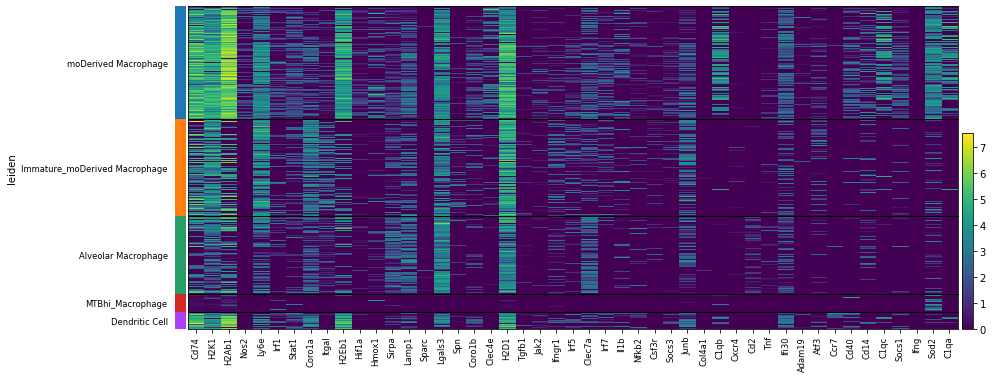

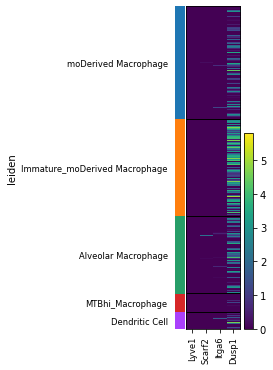

up near TB:  47 
down near TB: 4


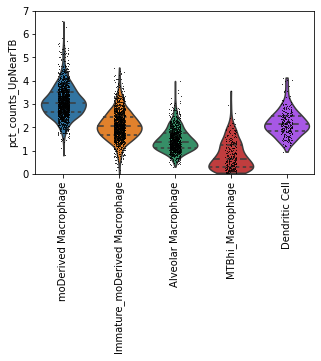

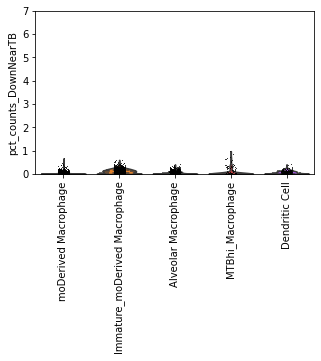

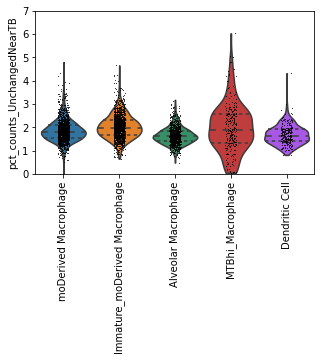

0.0003333333333333333


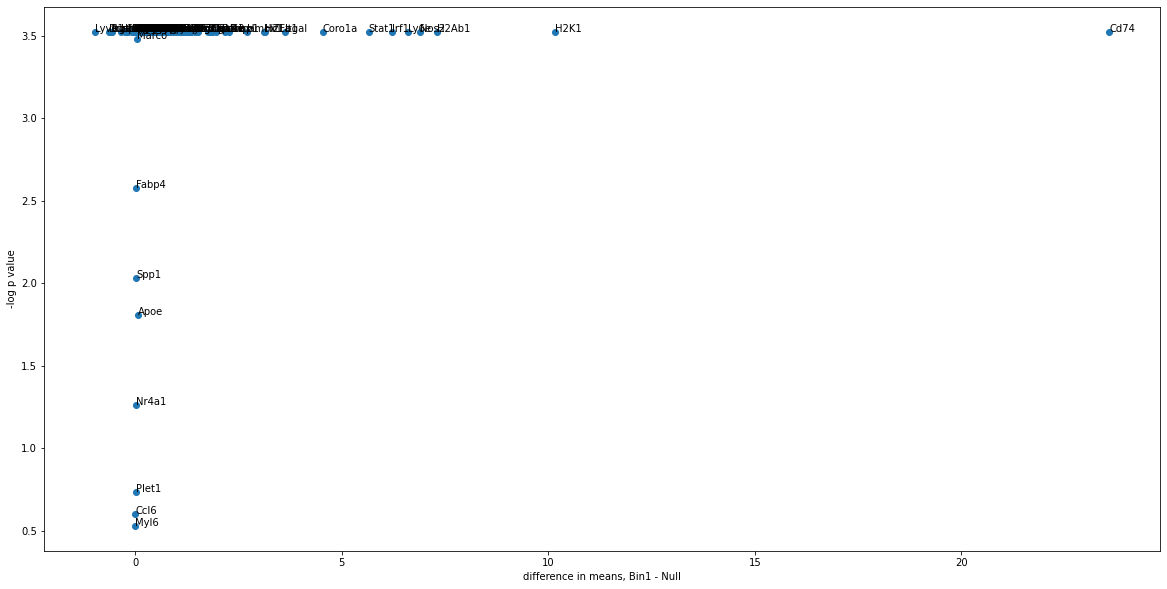

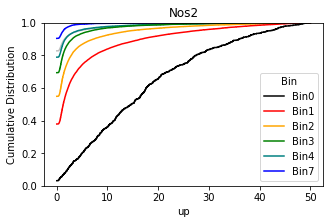

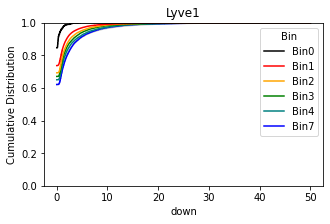

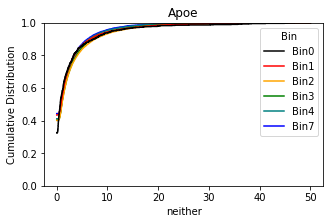

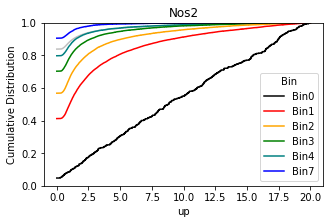

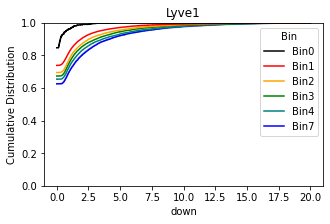

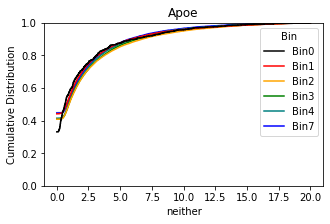

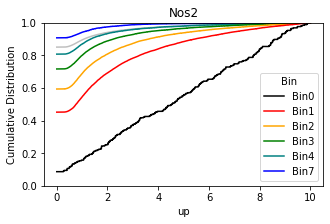

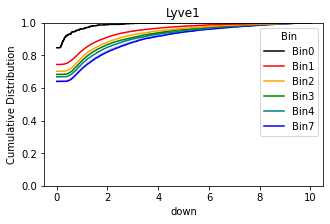

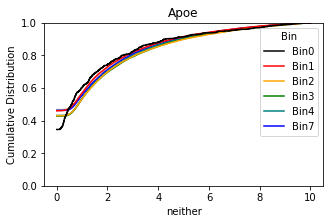

In [74]:
experimentName='AllTB'
region='All'
perm_iterations=1000
binsize=100

pval_threshold = 0.001
stat_threshold = 0.5

marker_dict = {'up':['Nos2'],
              'down':['Lyve1'],
              'neither':['Apoe']}

layer = 'normalized_to_polyT'

adata_tb = adata[adata.obs.Condition=='TB'].copy()

adata_df, df_results = permutation_test_for_tb_loc(adata_tb,layer,binsize,perm_iterations)
sc_data = plot_tb_altered_transcripts(sc_data,pval_threshold, stat_threshold, df_results,experimentName, region,perm_iterations)
plot_cumulative_dist(marker_dict,adata_df,experimentName,region,ymax=50)
plot_cumulative_dist(marker_dict,adata_df,experimentName,region,ymax=20)
plot_cumulative_dist(marker_dict,adata_df,experimentName,region,ymax=10)

number of cells per bin:  Null    64311
Bin1    49080
Bin7     2519
Bin4     1585
Bin3     1213
Bin2      960
Bin0       25
Name: Bin, dtype: int64


100%|██████████| 140/140 [1:15:03<00:00, 32.17s/it]


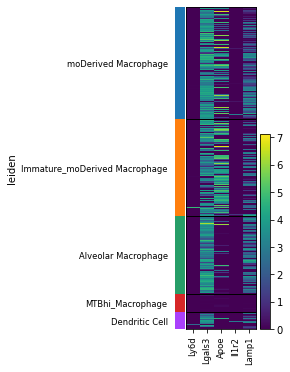

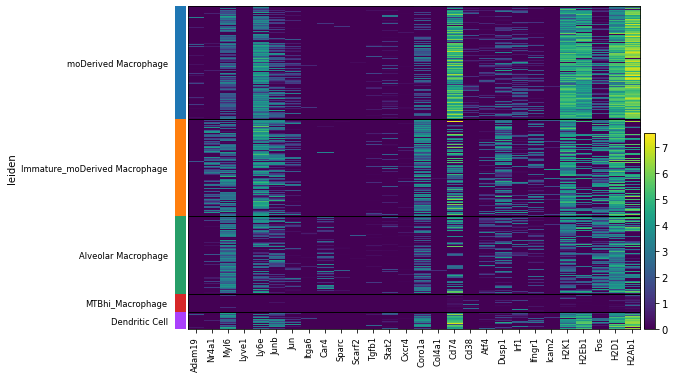

up near TB:  5 
down near TB: 28


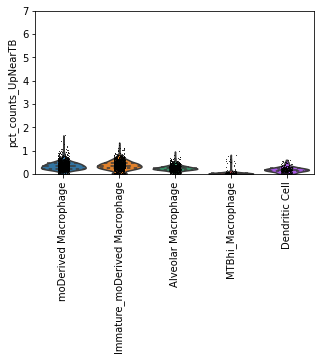

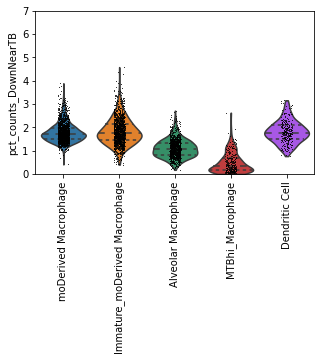

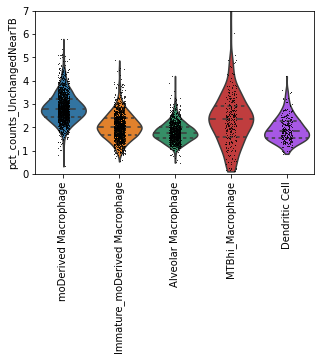

0.0006666666666666666


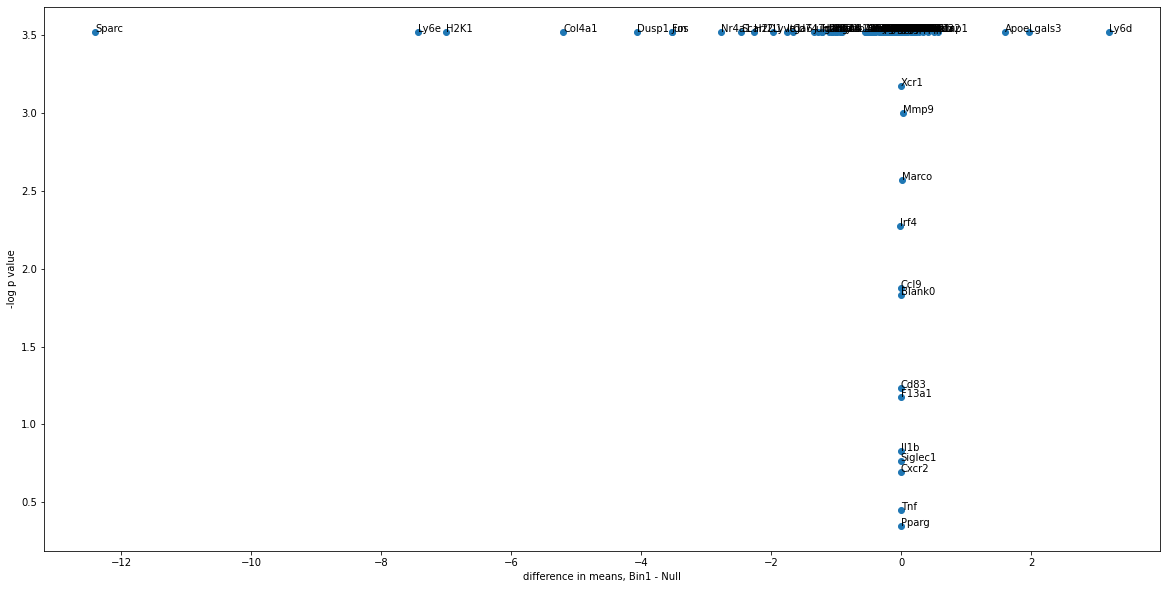

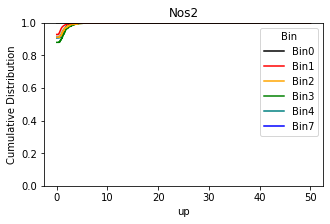

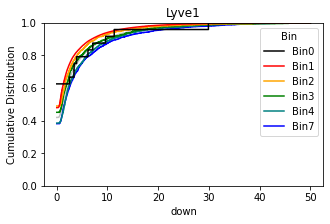

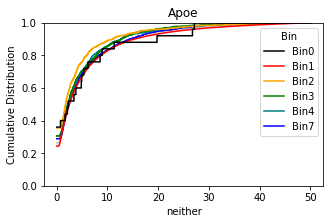

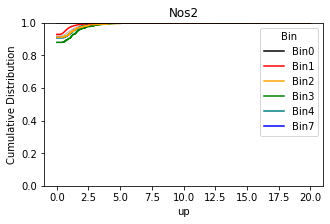

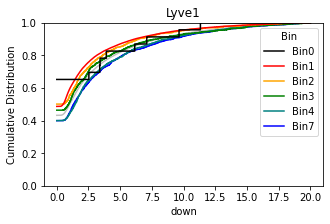

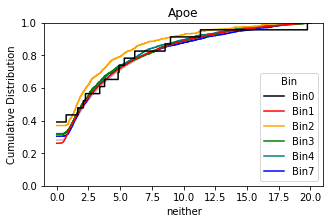

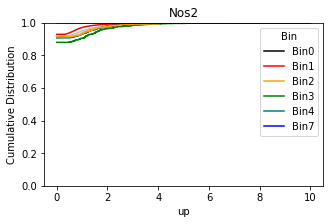

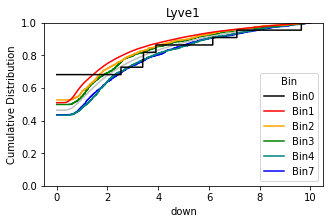

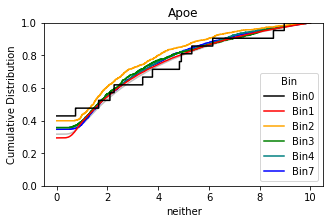

In [92]:
experimentName='AllControl'
region='All'
perm_iterations=1000
binsize=100

pval_threshold = 0.001
stat_threshold = 0.5

marker_dict = {'up':['Nos2'],
              'down':['Lyve1'],
              'neither':['Apoe']}

layer = 'normalized_to_polyT'

adata_tb = adata[adata.obs.Condition!='TB'].copy()

adata_df, df_results = permutation_test_for_tb_loc(adata_tb,layer,binsize,perm_iterations)
sc_data = plot_tb_altered_transcripts(sc_data,pval_threshold, stat_threshold, df_results,experimentName, region,perm_iterations)
plot_cumulative_dist(marker_dict,adata_df,experimentName,region,ymax=50)
plot_cumulative_dist(marker_dict,adata_df,experimentName,region,ymax=20)
plot_cumulative_dist(marker_dict,adata_df,experimentName,region,ymax=10)

In [ ]:
#from calculations with all samples together
#note: top 30 genes from this method and the previous method are completely overlapping except for c1qb
up_merged = sc_data.var.index[sc_data.var.UpNearTB]
up_merged

#from calculations with each sample separate 
#top 40
up_separate = average_df.sort_values('average',ascending=False)[:30].index
up_separate

for gene in list(up_merged):
    if gene in list(up_separate):
        print(gene, "is in both lists")
    else:
        print(gene, "is unique to the new calculation excluding TB+ cells")

Il1r2 is unique to the new calculation excluding TB+ cells
Apoe is unique to the new calculation excluding TB+ cells
Lamp1 is in both lists
Lgals3 is in both lists
Ly6d is unique to the new calculation excluding TB+ cells


### 4. Plot number of MTB+ cells from control and deprived FOV sections (Figure S6B-C)

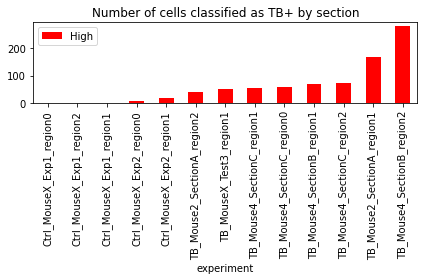

In [ ]:
df = pd.DataFrame(adata.obs.groupby(['full_sample','TB_class_from_images'])['slide'].count())
newdf = pd.DataFrame(index = list(set(adata.obs.full_sample)),columns = ['experiment','High','Low','Removed'])
for i,j in df.index:
    exp = i 
    tb_class = j
    value = df.loc[i,j][0]
    newdf.loc[i,j] = value
    
newdf.experiment = newdf.index.copy()
newdf_small = newdf[['experiment','High']]
newdf_small = newdf_small.sort_values("High")
index_order = newdf_small.index
#plot a bar plot
newdf_small.plot(x='experiment', kind='bar', stacked=True,
        title='Number of cells classified as TB+ by section',color = 'red')
plt.tight_layout()
plt.savefig(dataPath+'Figures/TB_pos_cells_by_sample_bar.pdf',format='pdf')
plt.show()

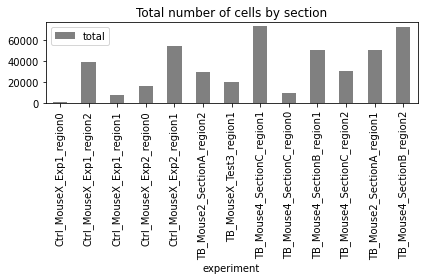

In [ ]:
newdf['total'] = newdf.High+newdf.Low+newdf.Removed
newdf_small = newdf[['experiment','total']]
newdf_small = newdf_small.loc[index_order]
newdf_small

#plot a bar plot
newdf_small.plot(x='experiment', kind='bar', stacked=True,
        title='Total number of cells by section',color = 'grey')
plt.tight_layout()
plt.savefig(dataPath+'Figures/all_cells_by_sample_bar.pdf',format='pdf')

plt.show()

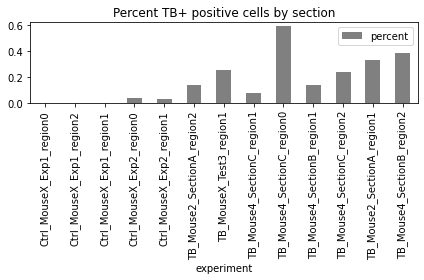

In [ ]:
newdf_small = newdf[['experiment','High','total']]
newdf_small['percent'] = newdf_small['High']*100/newdf_small['total']
newdf_small = newdf_small[['experiment','percent']]
newdf_small = newdf_small.loc[index_order]
newdf_small

#plot a bar plot
newdf_small.plot(x='experiment', kind='bar', stacked=True,
        title='Percent TB+ positive cells by section',color = 'grey')
plt.tight_layout()
plt.savefig(dataPath+'Figures/percent_tb_cells_by_sample_bar.pdf',format='pdf')

plt.show()

### 5. Validating that signature of TB-near cells is not present in control sections (where TB+ cells are rare artifacts)

In [98]:
#load in both data frames and compare the gene signatures
ctrl_stats = pd.read_csv(dataPath+'Stats/statsAllControl_regionAll.csv',index_col=0)
ctrl_stats

sample_stat  average_stat   p_value
Adam19     -0.550741     -0.225898  0.000300
Socs3      -0.213570     -0.087558  0.000300
Socs1      -0.159498     -0.065437  0.000300
Slamf1     -0.031580     -0.012958  0.000300
Sirpa      -0.163277     -0.066963  0.000300
...              ...           ...       ...
Il1b        0.004799      0.001905  0.147333
Siglec1    -0.003026     -0.001276  0.172667
Cxcr2      -0.002712     -0.001116  0.201333
Tnf         0.000994      0.000447  0.357000
Pparg      -0.001031     -0.000413  0.450000

[140 rows x 3 columns]

In [99]:
#load in both data frames and compare the gene signatures
tb_stats = pd.read_csv(dataPath+'Stats/statsAllTB_regionAll.csv',index_col=0)
tb_stats

sample_stat  average_stat   p_value
Adam19     0.756126      0.061642  0.000300
Stat1      5.652008      0.461045  0.000300
Spn        1.856221      0.149150  0.000300
Sod2       0.526754      0.044830  0.000300
Socs3      1.140094      0.094611  0.000300
...             ...           ...       ...
Apoe       0.070973      0.006128  0.015667
Nr4a1      0.022773      0.000253  0.054667
Plet1      0.007351     -0.000149  0.183667
Ccl6       0.004747      0.000691  0.252667
Myl6       0.002402     -0.000683  0.297333

[140 rows x 3 columns]

In [100]:
#for every gene, plot the tb sample_stat vs ctrl sample_stat
#make a combined data frame
all_stats = pd.DataFrame(index = tb_stats.index)
all_stats['tb_sample_stat'] = tb_stats['sample_stat'].copy()
all_stats['tb_pval'] = tb_stats['p_value'].copy()

for i in all_stats.index:
    all_stats.loc[i,'Ctrl_sample_stat'] = ctrl_stats.loc[i,'sample_stat']
    all_stats.loc[i,'Ctrl_sample_pval'] = ctrl_stats.loc[i,'p_value']
    
all_stats

tb_sample_stat   tb_pval  Ctrl_sample_stat  Ctrl_sample_pval
Adam19        0.756126  0.000300         -0.550741            0.0003
Stat1         5.652008  0.000300         -0.465628            0.0003
Spn           1.856221  0.000300         -0.341234            0.0003
Sod2          0.526754  0.000300          0.150732            0.0003
Socs3         1.140094  0.000300         -0.213570            0.0003
...                ...       ...               ...               ...
Apoe          0.070973  0.015667          1.605032            0.0003
Nr4a1         0.022773  0.054667         -2.768293            0.0003
Plet1         0.007351  0.183667          0.208319            0.0003
Ccl6          0.004747  0.252667          0.038602            0.0003
Myl6          0.002402  0.297333         -0.979480            0.0003

[140 rows x 4 columns]

        tb_sample_stat  tb_pval  Ctrl_sample_stat  Ctrl_sample_pval    gene
Lyve1        -0.977415   0.0003         -1.963995            0.0003   Lyve1
Dusp1        -0.633709   0.0003         -4.057876            0.0003   Dusp1
Scarf2       -0.602215   0.0003         -2.460901            0.0003  Scarf2
Itga6        -0.554029   0.0003         -1.753998            0.0003   Itga6
Jun          -0.350197   0.0003         -3.525540            0.0003     Jun
...                ...      ...               ...               ...     ...
Ly6e          6.596034   0.0003         -7.434102            0.0003    Ly6e
Nos2          6.903807   0.0003         -0.070943            0.0003    Nos2
H2Ab1         7.304274   0.0003         -1.015706            0.0003   H2Ab1
H2K1         10.165484   0.0003         -7.001717            0.0003    H2K1
Cd74         23.585731   0.0003         -1.663442            0.0003    Cd74

[102 rows x 5 columns]


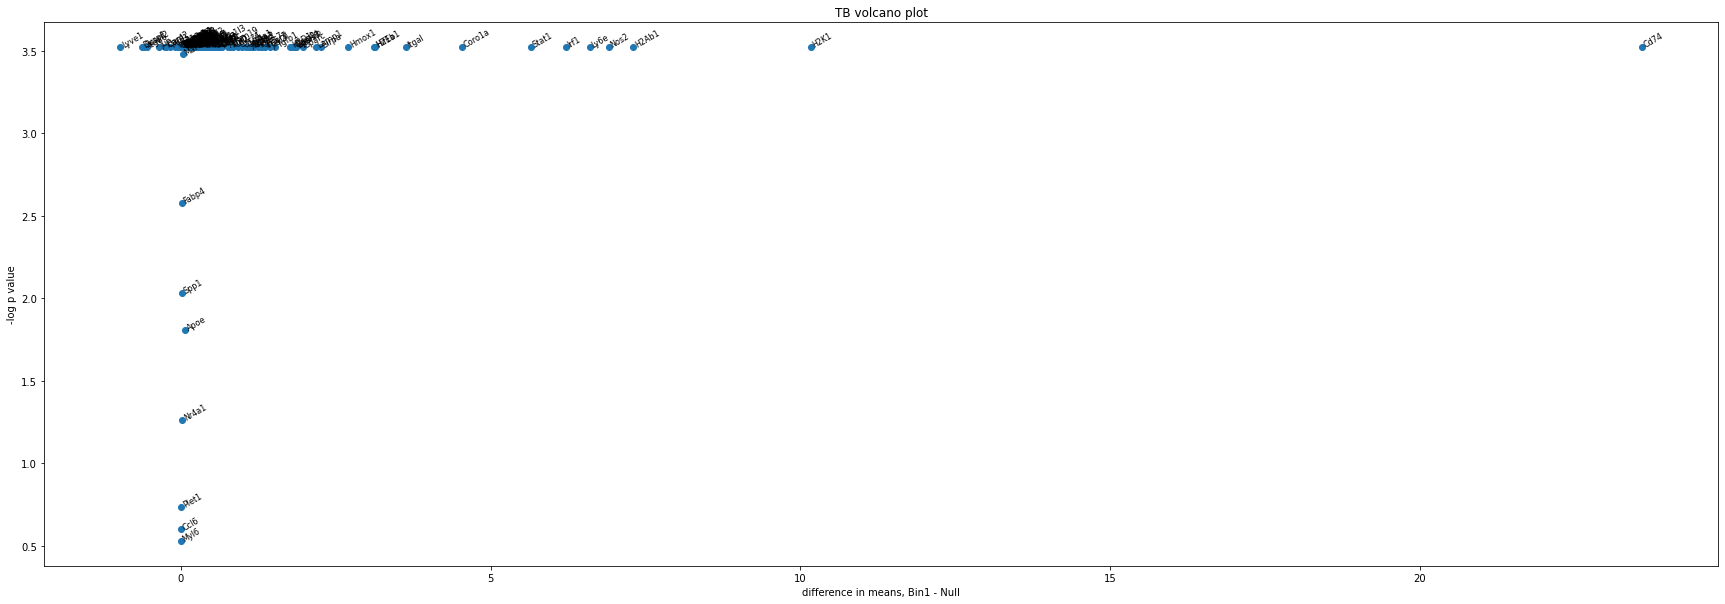

In [101]:
#sort by tb_sample_stat and plot both tb and control stats
all_stats = all_stats.sort_values('tb_sample_stat')
all_stats['gene'] = all_stats.index.copy()

#plot a volcano plot
fig, ax = plt.subplots(figsize=(30,10))
ax.scatter(x = all_stats.tb_sample_stat, y=-np.log10(all_stats.tb_pval))
ax.set_xlabel('difference in means, Bin1 - Null')
ax.set_ylabel('-log p value')
ax.set_title('TB volcano plot')

for i in range(all_stats.shape[0]):
 ax.text(x=all_stats.tb_sample_stat[i],y=-np.log10(all_stats.tb_pval[i]),s=all_stats.gene[i], 
          color='black',size=8,rotation=30)

print(all_stats.loc[abs(all_stats.tb_sample_stat)>0.1])

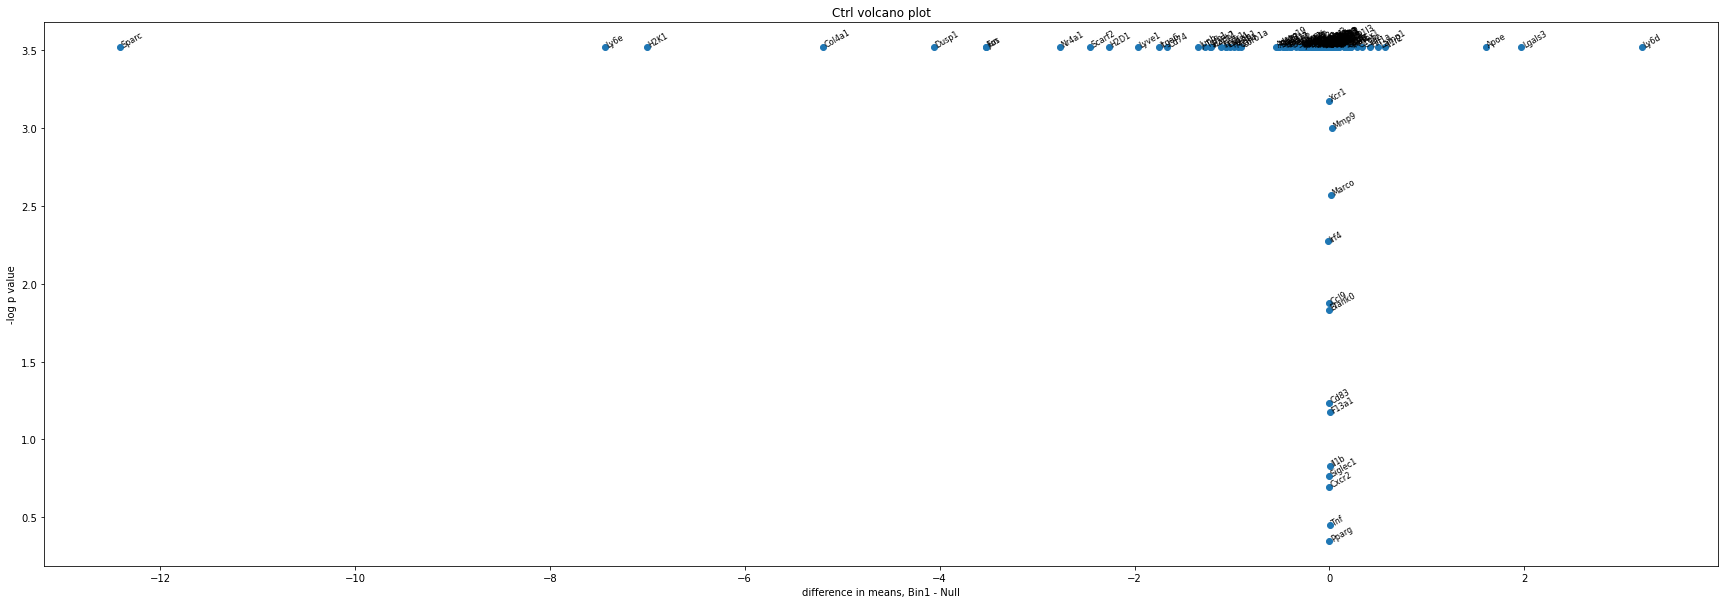

In [102]:
#plot a volcano plot
fig, ax = plt.subplots(figsize=(30,10))
ax.scatter(x = all_stats.Ctrl_sample_stat, y=-np.log10(all_stats.Ctrl_sample_pval))
ax.set_xlabel('difference in means, Bin1 - Null')
ax.set_ylabel('-log p value')
ax.set_title('Ctrl volcano plot')

for i in range(all_stats.shape[0]):
 ax.text(x=all_stats.Ctrl_sample_stat[i],y=-np.log10(all_stats.Ctrl_sample_pval[i]),s=all_stats.gene[i], 
          color='black',size=8,rotation=30)

In [103]:
#make a table comparing the genes that are significantly altered in the TB samples vs those significantly altered in the control samples
tb_up = all_stats.gene[all_stats.tb_sample_stat>0.05]
tb_down = all_stats.gene[all_stats.tb_sample_stat<-0.05]
tb_neither = all_stats.gene[(all_stats.tb_sample_stat<0.05)&(all_stats.tb_sample_stat>-0.05)]

In [104]:
print(len(tb_up))
x = all_stats.loc[tb_up,'Ctrl_sample_stat']>0.05
all_stats.loc[x[x].index]

103


tb_sample_stat   tb_pval  Ctrl_sample_stat  Ctrl_sample_pval  \
Apoe            0.070973  0.015667          1.605032            0.0003   
Ly6d            0.111328  0.000300          3.208362            0.0003   
Crebbp          0.143857  0.000300          0.060827            0.0003   
Hspa8           0.161581  0.000300          0.069969            0.0003   
Il1r2           0.227598  0.000300          0.565969            0.0003   
Nr4a3           0.392237  0.000300          0.086788            0.0003   
Mafb            0.400411  0.000300          0.186115            0.0003   
Dnase1l3        0.485345  0.000300          0.098541            0.0003   
C1qa            0.522257  0.000300          0.167670            0.0003   
Sod2            0.526754  0.000300          0.150732            0.0003   
C1qc            0.578657  0.000300          0.337295            0.0003   
Cd14            0.616112  0.000300          0.073938            0.0003   
Ifi30           0.784819  0.000300          0.211262            0.0003   
C1qb            0.981223  0.000300          0.281421            0.0003   
Irf5            1.340429  0.000300          0.161898            0.0003   
Lgals3          1.858169  0.000300          1.968635            0.0003   
Lamp1           2.182996  0.000300          0.502112            0.0003   
Hmox1           2.705364  0.000300          0.224598            0.0003   
Hif1a           3.123518  0.000300          0.417731            0.0003   

              gene  
Apoe          Apoe  
Ly6d          Ly6d  
Crebbp      Crebbp  
Hspa8        Hspa8  
Il1r2        Il1r2  
Nr4a3        Nr4a3  
Mafb          Mafb  
Dnase1l3  Dnase1l3  
C1qa          C1qa  
Sod2          Sod2  
C1qc          C1qc  
Cd14          Cd14  
Ifi30        Ifi30  
C1qb          C1qb  
Irf5          Irf5  
Lgals3      Lgals3  
Lamp1        Lamp1  
Hmox1        Hmox1  
Hif1a        Hif1a

In [105]:
print(len(tb_down))
x = all_stats.loc[tb_down,'Ctrl_sample_stat']<-0.05
all_stats.loc[x[x].index]

9


tb_sample_stat  tb_pval  Ctrl_sample_stat  Ctrl_sample_pval    gene
Lyve1        -0.977415   0.0003         -1.963995            0.0003   Lyve1
Dusp1        -0.633709   0.0003         -4.057876            0.0003   Dusp1
Scarf2       -0.602215   0.0003         -2.460901            0.0003  Scarf2
Itga6        -0.554029   0.0003         -1.753998            0.0003   Itga6
Jun          -0.350197   0.0003         -3.525540            0.0003     Jun
Icam2        -0.254962   0.0003         -1.221322            0.0003   Icam2
Car4         -0.236443   0.0003         -0.941339            0.0003    Car4
Irs2         -0.088079   0.0003         -0.476649            0.0003    Irs2

In [109]:
tb_up = tb_up[~tb_up.isin(['C1qa','C1qb'])]
tb_down = tb_down[~tb_down.isin(['Lyve1','Dusp1','Itga6','Scarf2','Ly6e','Atf4','Col4a1','H2D1','Car4','Lamp1'])]

tb_up = [i for i in tb_up if not i.startswith('Blank')]
tb_down = [i for i in tb_down if not i.startswith('Blank')]

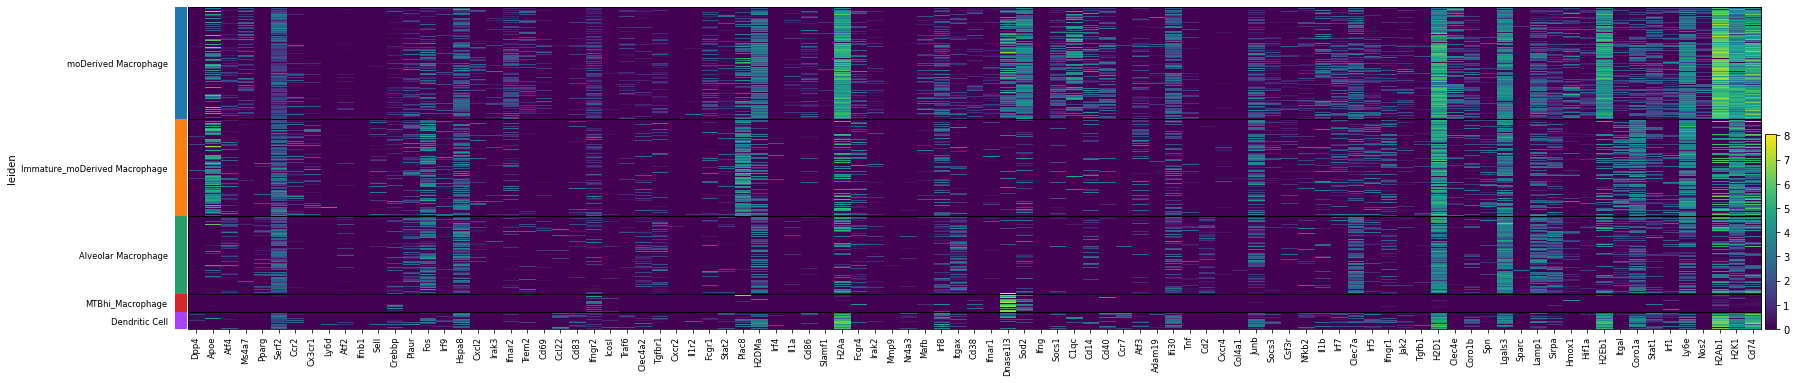

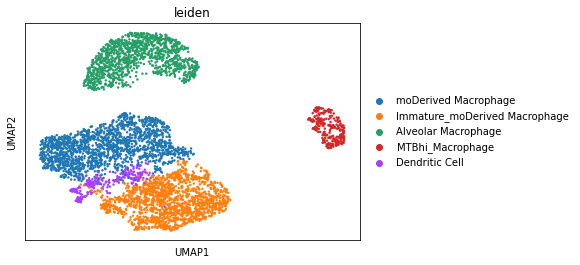

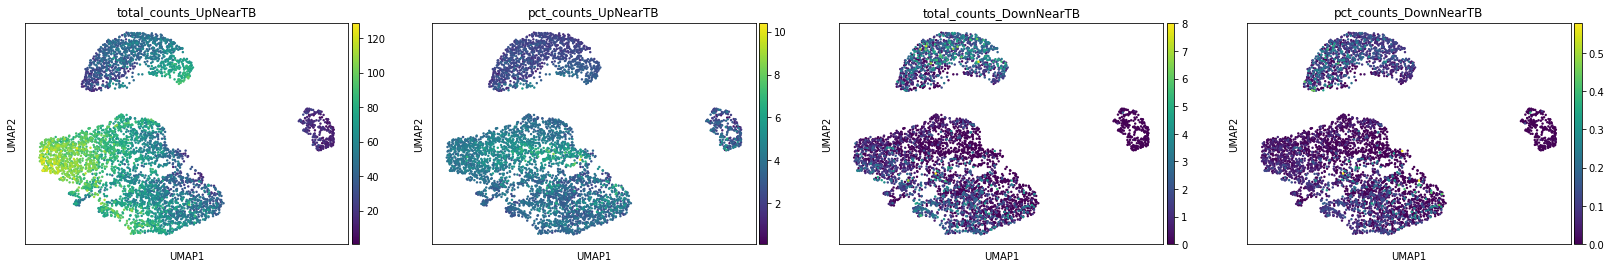

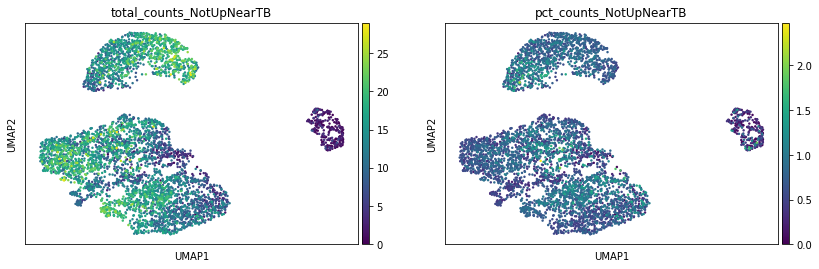

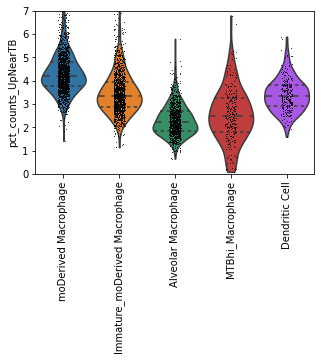

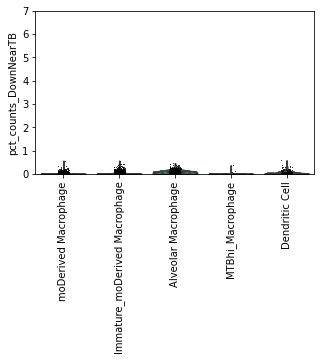

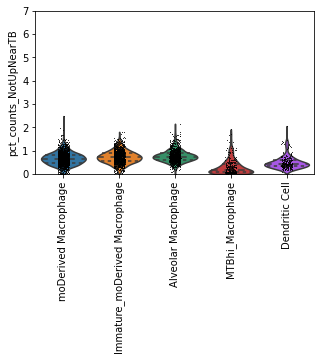

In [111]:
#re-run the violin plots with these genes
condition = 'TBsubtractingControls_All'
allprobes = [i for i in list(all_stats.index) if not i.startswith('Blank')]

sc_data.var['UpNearTB'] = False
sc_data.var.loc[sc_data.var.index.isin(tb_up),'UpNearTB'] = True

sc_data.var['DownNearTB'] = False
sc_data.var.loc[sc_data.var.index.isin(tb_down),'DownNearTB'] = True

sc_data.var['NotUpNearTB'] = False
sc_data.var.loc[sc_data.var.index.isin(allprobes),'NotUpNearTB'] = True
sc_data.var.loc[sc_data.var['UpNearTB']==True,'NotUpNearTB'] = False
sc_data.var.loc[sc_data.var['DownNearTB']==True,'NotUpNearTB'] = False

sc.pl.heatmap(sc_data,tb_up,groupby='leiden',show_gene_labels=True)
sc.pp.calculate_qc_metrics(sc_data,qc_vars=['UpNearTB','DownNearTB','NotUpNearTB'],inplace=True)
sc.pl.umap(sc_data,color = ['leiden'])
sc.pl.umap(sc_data,color = ['total_counts_UpNearTB','pct_counts_UpNearTB','total_counts_DownNearTB','pct_counts_DownNearTB'])
sc.pl.umap(sc_data,color = ['total_counts_NotUpNearTB','pct_counts_NotUpNearTB'])

fig,ax = plt.subplots(figsize=(5,3))
ax.set_ylim(0,7)
#sc.pl.violin(sc_data,['total_counts_UpNearTB','pct_counts_UpNearTB','total_counts_DownNearTB','pct_counts_DownNearTB'],groupby='leiden',rotation=90)
sc.pl.violin(sc_data,['pct_counts_UpNearTB'],groupby='leiden',rotation=90,inner='quartile',save = 'AllFiles_'+condition+'_ViolinPlot_UP_limit01_strict_TB.pdf',ax=ax)
fig,ax = plt.subplots(figsize=(5,3))
ax.set_ylim(0,7)
sc.pl.violin(sc_data,['pct_counts_DownNearTB'],groupby='leiden',rotation=90,inner='quartile',save = 'AllFiles_'+condition+'_ViolinPlot_Down_limit01_strict_TB.pdf',ax=ax)

fig,ax = plt.subplots(figsize=(5,3))
ax.set_ylim(0,7)
sc.pl.violin(sc_data,['pct_counts_NotUpNearTB'],groupby='leiden',rotation=90,inner='quartile',save = 'AllFiles_'+condition+'_ViolinPlot_NEITHER_limit01_strict_TB.pdf',ax=ax)
             

### 6. Selecting cells that are confidently Monocyte/Macrophages

In [112]:
#list from tabula muris senis specific to myeloid cells, expressed in all myeloid cells but no others:
gene_list_from_tms = ['C1qb',
 'C1qc',
 'Clec4a2',
 'Dnase1l3',
 'Ms4a7',
 'Sell',
 'Trem2',
 'Mmp9',
 'Clec4e']

marker_list_threshold = 5 #threshold for how many counts of the above need to be in a cell
marker_dict = {'High':['Nos2'], 'Low':['Lyve1'],'Neither':['Apoe']}

cells with marker gene expression:  71735


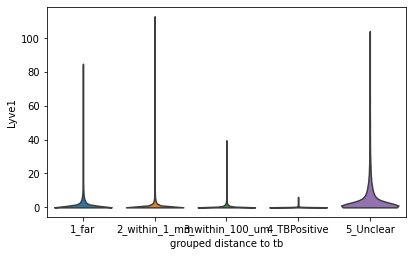

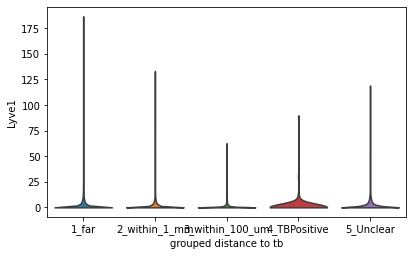

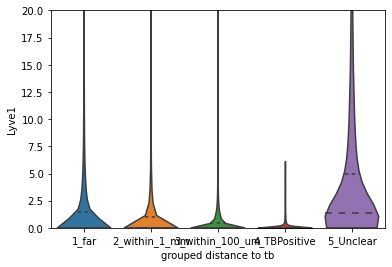

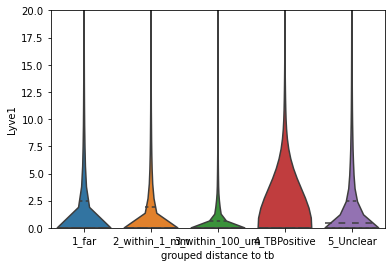

In [113]:
#show Lyve1 expression in super confident macrophages
#calculate qc metrics for MarkerGenes
#add info to the adata object
adata.var['MarkerGenes'] = False
adata.var.loc[adata.var.index.isin(gene_list_from_tms),'MarkerGenes'] = True

sc.pp.calculate_qc_metrics(adata, expr_type='counts', percent_top=None,qc_vars=['MarkerGenes'], layer='counts', inplace=True, log1p=False)

cm = adata[adata.obs.total_counts_MarkerGenes>5].shape[0]
    #show how many cells have any of the marker genes
print("cells with marker gene expression: ", cm)
    
    #assign confident macrophages
adata.obs['confident_celltype'] = 'Unknown'
adata.obs.loc[adata.obs.total_counts_MarkerGenes>marker_list_threshold,'confident_celltype'] = 'Immune'

#show Lyve1 expression
sc.pl.violin(adata[adata.obs.confident_celltype=='Immune'],'Lyve1',groupby='grouped_distance_to_tb',stripplot=False,layer='normalized_to_polyT')
sc.pl.violin(adata[adata.obs.confident_celltype=='Unknown'],'Lyve1',groupby='grouped_distance_to_tb',stripplot=False,layer='normalized_to_polyT')

fig,ax = plt.subplots()
ax.set_ylim(0,20)
#ax.set_yscale('log')
sc.pl.violin(adata[adata.obs.confident_celltype=='Immune'],'Lyve1',groupby='grouped_distance_to_tb',stripplot=False,layer='normalized_to_polyT',inner='quartile',title='MonoMac',ax=ax,
             save='_immune_lyve1_violin.pdf')

fig,ax = plt.subplots()
ax.set_ylim(0,20)
sc.pl.violin(adata[adata.obs.confident_celltype=='Unknown'],'Lyve1',
             groupby='grouped_distance_to_tb',stripplot=False,
             layer='normalized_to_polyT',inner='quartile',
             title='Remainder',ax=ax,save='_remainder_lyve1_violin.pdf')

number of cells per bin:  Null    239536
Bin1     27586
Bin2     25234
Bin3     17320
Bin4     14167
Bin7     10609
Bin0       794
Name: Bin, dtype: int64


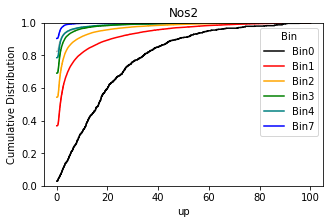

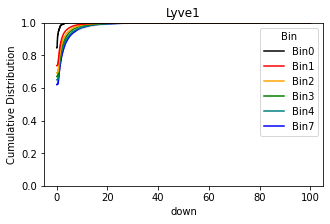

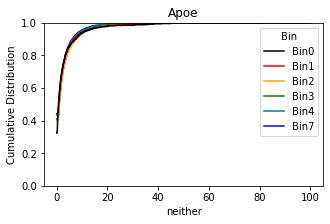

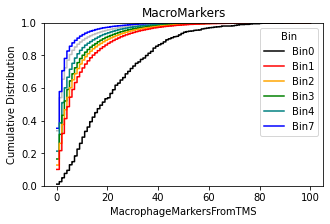

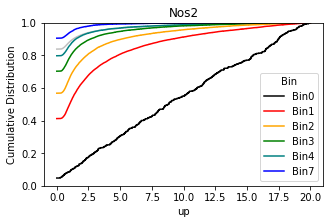

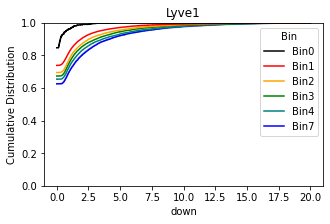

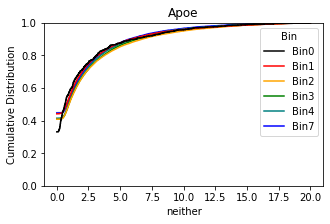

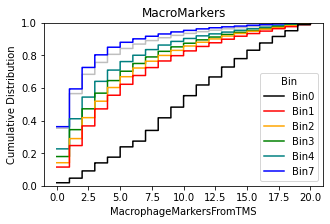

In [114]:
#remake some of the cumulative distribution plots with confident cell type markers
experimentName='AllTB_ConfidentMonoMac'
region='All'

binsize=100

marker_dict = {'up':['Nos2'], #['Cd74','H2K1','Nos2','C1qb','Hmox1']
              'down':['Lyve1'],
              'neither':['Apoe'],
              'MacrophageMarkersFromTMS':['MacroMarkers']}

layer = 'normalized_to_polyT'


adata_tb = adata[adata.obs.Condition=='TB'].copy()

#add a column to adata_df with the summed counts of the macrophage markers
if isinstance(adata_tb.layers[layer], scipy.sparse._csr.csr_matrix):
    adata_df = pd.DataFrame.sparse.from_spmatrix(adata_tb.layers[layer])
    adata_df = adata_df.sparse.to_dense()
else:
    adata_df = pd.DataFrame(adata_tb.layers[layer])
adata_df.columns = adata_tb.var.index
adata_df.index = adata_tb.obs.index
adata_df['MacroMarkers'] = adata_tb.obs.total_counts_MarkerGenes.copy()
adata_df['distance_real'] = adata_tb.obs['distance_to_tb'].copy()
adata_df.columns = [i.replace('-','') for i in adata_df.columns]
adata_df['Bin'] = 'Null'
#for the first 4 bins, plot the distribution on top of this one in a different color
adata_df.loc[(adata_df.distance_real>=6*binsize) & (adata_df.distance_real<7*binsize),'Bin'] = 'Bin7'
adata_df.loc[(adata_df.distance_real>=3*binsize) & (adata_df.distance_real<4*binsize),'Bin'] = 'Bin4'
adata_df.loc[(adata_df.distance_real>=2*binsize) & (adata_df.distance_real<3*binsize),'Bin'] = 'Bin3'
adata_df.loc[(adata_df.distance_real>=binsize) & (adata_df.distance_real<2*binsize),'Bin'] = 'Bin2'
adata_df.loc[adata_df.distance_real<binsize,'Bin'] = 'Bin1'
adata_df.loc[adata_df.distance_real==0,'Bin'] = 'Bin0'
print("number of cells per bin: ",adata_df.Bin.value_counts())
adata_df = adata_df.sort_values('Bin',ascending=True)

plot_cumulative_dist(marker_dict,adata_df,experimentName,region,ymax=100)
plot_cumulative_dist(marker_dict,adata_df,experimentName,region,ymax=20)

In [141]:
adata_sub = adata[adata.obs.grouped_distance_to_tb.isin(['3_within_100_um','4_TBPositive'])].copy()
adata_sub = adata_sub[adata_sub.obs.confident_celltype=='Immune'].copy()
adata_sub

layer = 'normalized_to_polyT'
if isinstance(adata_sub.layers[layer], scipy.sparse._csr.csr_matrix):
    adata_df = pd.DataFrame.sparse.from_spmatrix(adata_sub.layers[layer])
    adata_df = adata_df.sparse.to_dense()
else:
    adata_df = pd.DataFrame(adata_sub.layers[layer])
adata_df.columns = adata_sub.var.index
adata_df.index = adata_sub.obs.index
adata_df['Bin'] = adata_sub.obs['grouped_distance_to_tb'].copy()
adata_df.columns = [i.replace('-','') for i in adata_df.columns]

#permutation test ~43 iterations/second
df_results = pd.DataFrame(columns=['sample_stat','average_stat','p_value'])
for transcript in tqdm(adata_df.columns[:140]):
    ref_average = np.mean(adata_df.loc[adata_df['Bin']=='3_within_100_um',transcript])
        #print(ref_average)
                              
    sample_stat = np.mean(adata_df.loc[adata_df['Bin']=='4_TBPositive',transcript]) - ref_average #calculate the difference in means between your bin1 distribution and the null distribution
    stats = np.zeros(perm_iterations)
    for k in range(perm_iterations):
        labels = np.random.permutation((adata_df['Bin'] == '4_TBPositive').values) #randomly rearrange the bin labels so you get another sample in 'Bin1'
        stats[k] = np.mean(adata_df[transcript][labels]) - ref_average #for each of 1000 iterations, calculate the difference between the random Bin1 Nos2 values and the null distribution
    
    if sample_stat>=0:
        p_value = np.mean(stats > sample_stat)
    if sample_stat<0:
        p_value = np.mean(stats < sample_stat)
    #save the stat and p-value per transcript
    df_results.loc[transcript] = [sample_stat,np.mean(stats),p_value] 

df_results = df_results.sort_values('p_value',ascending=True)



100%|██████████| 140/140 [01:07<00:00,  2.09it/s]


0.001


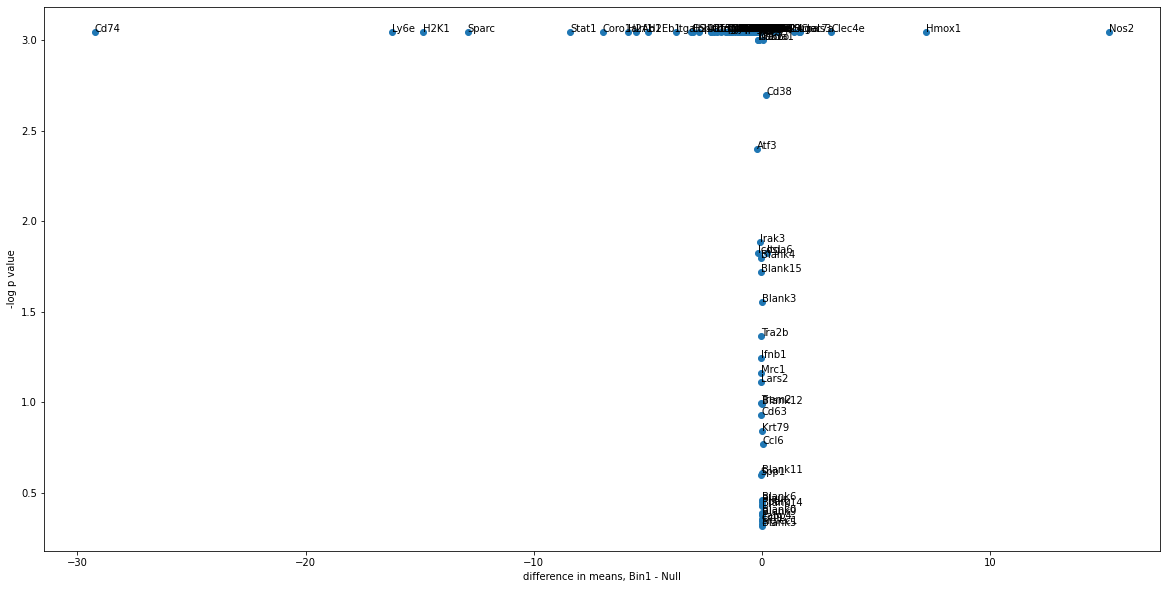

In [142]:
df_results = df_results.sort_values('sample_stat',ascending=False)
print(df_results.p_value[df_results.p_value>0].min())
df_results.loc[df_results.p_value==0,'p_value'] = 0.9/perm_iterations
df_results.to_csv(dataPath+'Stats/AllMonoMacInfectedVsNeighbors.csv')

plt.figure(figsize=(20,10))
plt.scatter(x = df_results.sample_stat, y=-np.log10(df_results.p_value))
plt.xlabel('difference in means, Bin1 - Null')
plt.ylabel('-log p value')

for i in range(df_results.shape[0]):
    plt.text(x=df_results.sample_stat[i],y=-np.log10(df_results.p_value[i]),s=df_results.index[i], 
            fontdict=dict(color='black',size=10))
    
plt.savefig(dataPath+'Figures/volcano_InfectedVsNeighbors.pdf')

### Figure 7A

In [143]:
df_results['gene'] = df_results.index.copy()
df_results

sample_stat  average_stat  p_value    gene
Nos2      15.229986      0.798275   0.0009    Nos2
Hmox1      7.171810      0.362914   0.0009   Hmox1
Clec4e     3.040754      0.165750   0.0009  Clec4e
Clec7a     1.687438      0.089887   0.0009  Clec7a
Lgals3     1.623355      0.083871   0.0009  Lgals3
...             ...           ...      ...     ...
Stat1     -8.411355     -0.450626   0.0009   Stat1
Sparc    -12.889348     -0.684105   0.0009   Sparc
H2K1     -14.858499     -0.791361   0.0009    H2K1
Ly6e     -16.194107     -0.884570   0.0009    Ly6e
Cd74     -29.229474     -1.474785   0.0009    Cd74

[140 rows x 4 columns]

In [149]:
df_results.loc['Sirpa']

sample_stat     1.391451
average_stat    0.069944
p_value           0.0009
gene               Sirpa
Name: Sirpa, dtype: object

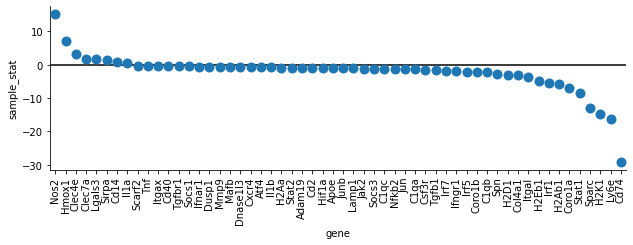

In [153]:
ax = sns.catplot(data=df_results[(df_results.p_value<0.001)&(abs(df_results.sample_stat)>0.5)], 
                 x="gene", 
                 y="sample_stat",  
                 kind="swarm",
                 aspect=3,
                 height=3,
                 s=100,
                 row_order=gene_list)
ax.set_xticklabels(rotation=90)
plt.axhline(0,c='black')
plt.savefig(dataPath+"Figures/monomac_swarmplot_TBPos_vs_Neighbors.pdf", format='pdf')
plt.show()

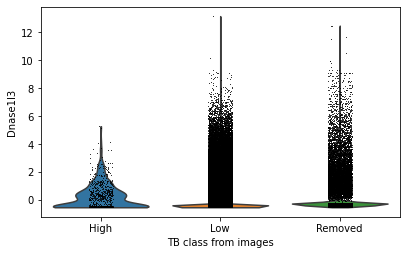

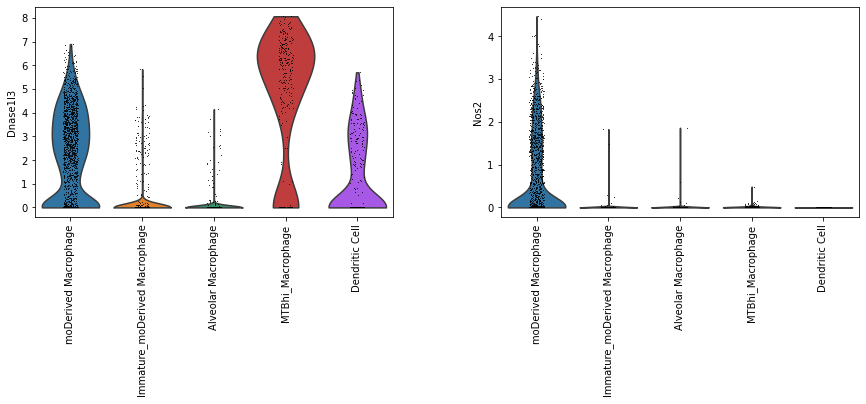

In [154]:
#show Dnase1l3 expression 
sc.pl.violin(adata,'Dnase1l3',groupby='TB_class_from_images')
sc.pl.violin(sc_data,['Dnase1l3','Nos2'],groupby='leiden',rotation=90)